In [1]:
from pynvml import *

nvmlInit()
vram = nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(0)).free/1024.**2
print('GPU0 Memory: %dMB' % vram)
if vram < 8000:
    raise Exception('GPU Memory too low')
nvmlShutdown()

# 引用及参数

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

char_dir = 'G:\\my_code\\python\\MTWI2018\\char_std_6885.txt'
characters=''
char_to_id = {}
id_to_char = {}
with open(char_dir,encoding='utf-8') as f:
      for ch in f.readlines():
            ch = ch.strip('\r\n')
            characters=characters+ch
#characters =characters+'^'
print('nclass:',len(characters))
    
char_to_id = {j:i for i,j in enumerate(characters)}
id_to_char = {i:j for i,j in enumerate(characters)}
id_to_char[-1]=''
    
width, height, n_len, n_class = 200, 32, 50, len(characters) + 1
print(n_class)    

In [3]:
print(id_to_char)

# 定义 CTC Loss

In [4]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    #y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


# 定义网络结构

In [5]:
from keras.layers import *
from keras.models import *
from make_parallel import make_parallel
rnn_size = 128

input_tensor = Input((width, height, 3))
x = input_tensor
for i in range(1):
    x = Conv2D(32*2**i, (3, 3), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32*2**i, (3, 3), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

conv_shape = x.get_shape()
print(conv_shape)
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)
conv_shape1 = x.get_shape()
print('')
print('conv_shape1')
print(conv_shape1)
x = Dense(128, kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
conv_shape2 = x.get_shape()
print('')
print('conv_shape2')
print(conv_shape2)

gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
             name='gru1_b')(x)
gru1_merged = add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
             name='gru2_b')(gru1_merged)
x = concatenate([gru_2, gru_2b])
x = Dropout(0.25)(x)
x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
base_model = Model(input=input_tensor, output=x)

#base_model2 = make_parallel(base_model, 4)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')
#loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([base_model.output, labels, input_length, label_length])
loss_out = Lambda(ctc_lambda_func, name='ctc')([base_model.output, labels, input_length, label_length])

model = Model(inputs=(input_tensor, labels, input_length, label_length), outputs=loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

(?, 98, 14, 32)

conv_shape1
(?, 98, 448)

conv_shape2
(?, 98, 128)


d:\ProgramData\Anaconda3\envs\captcha_demo\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


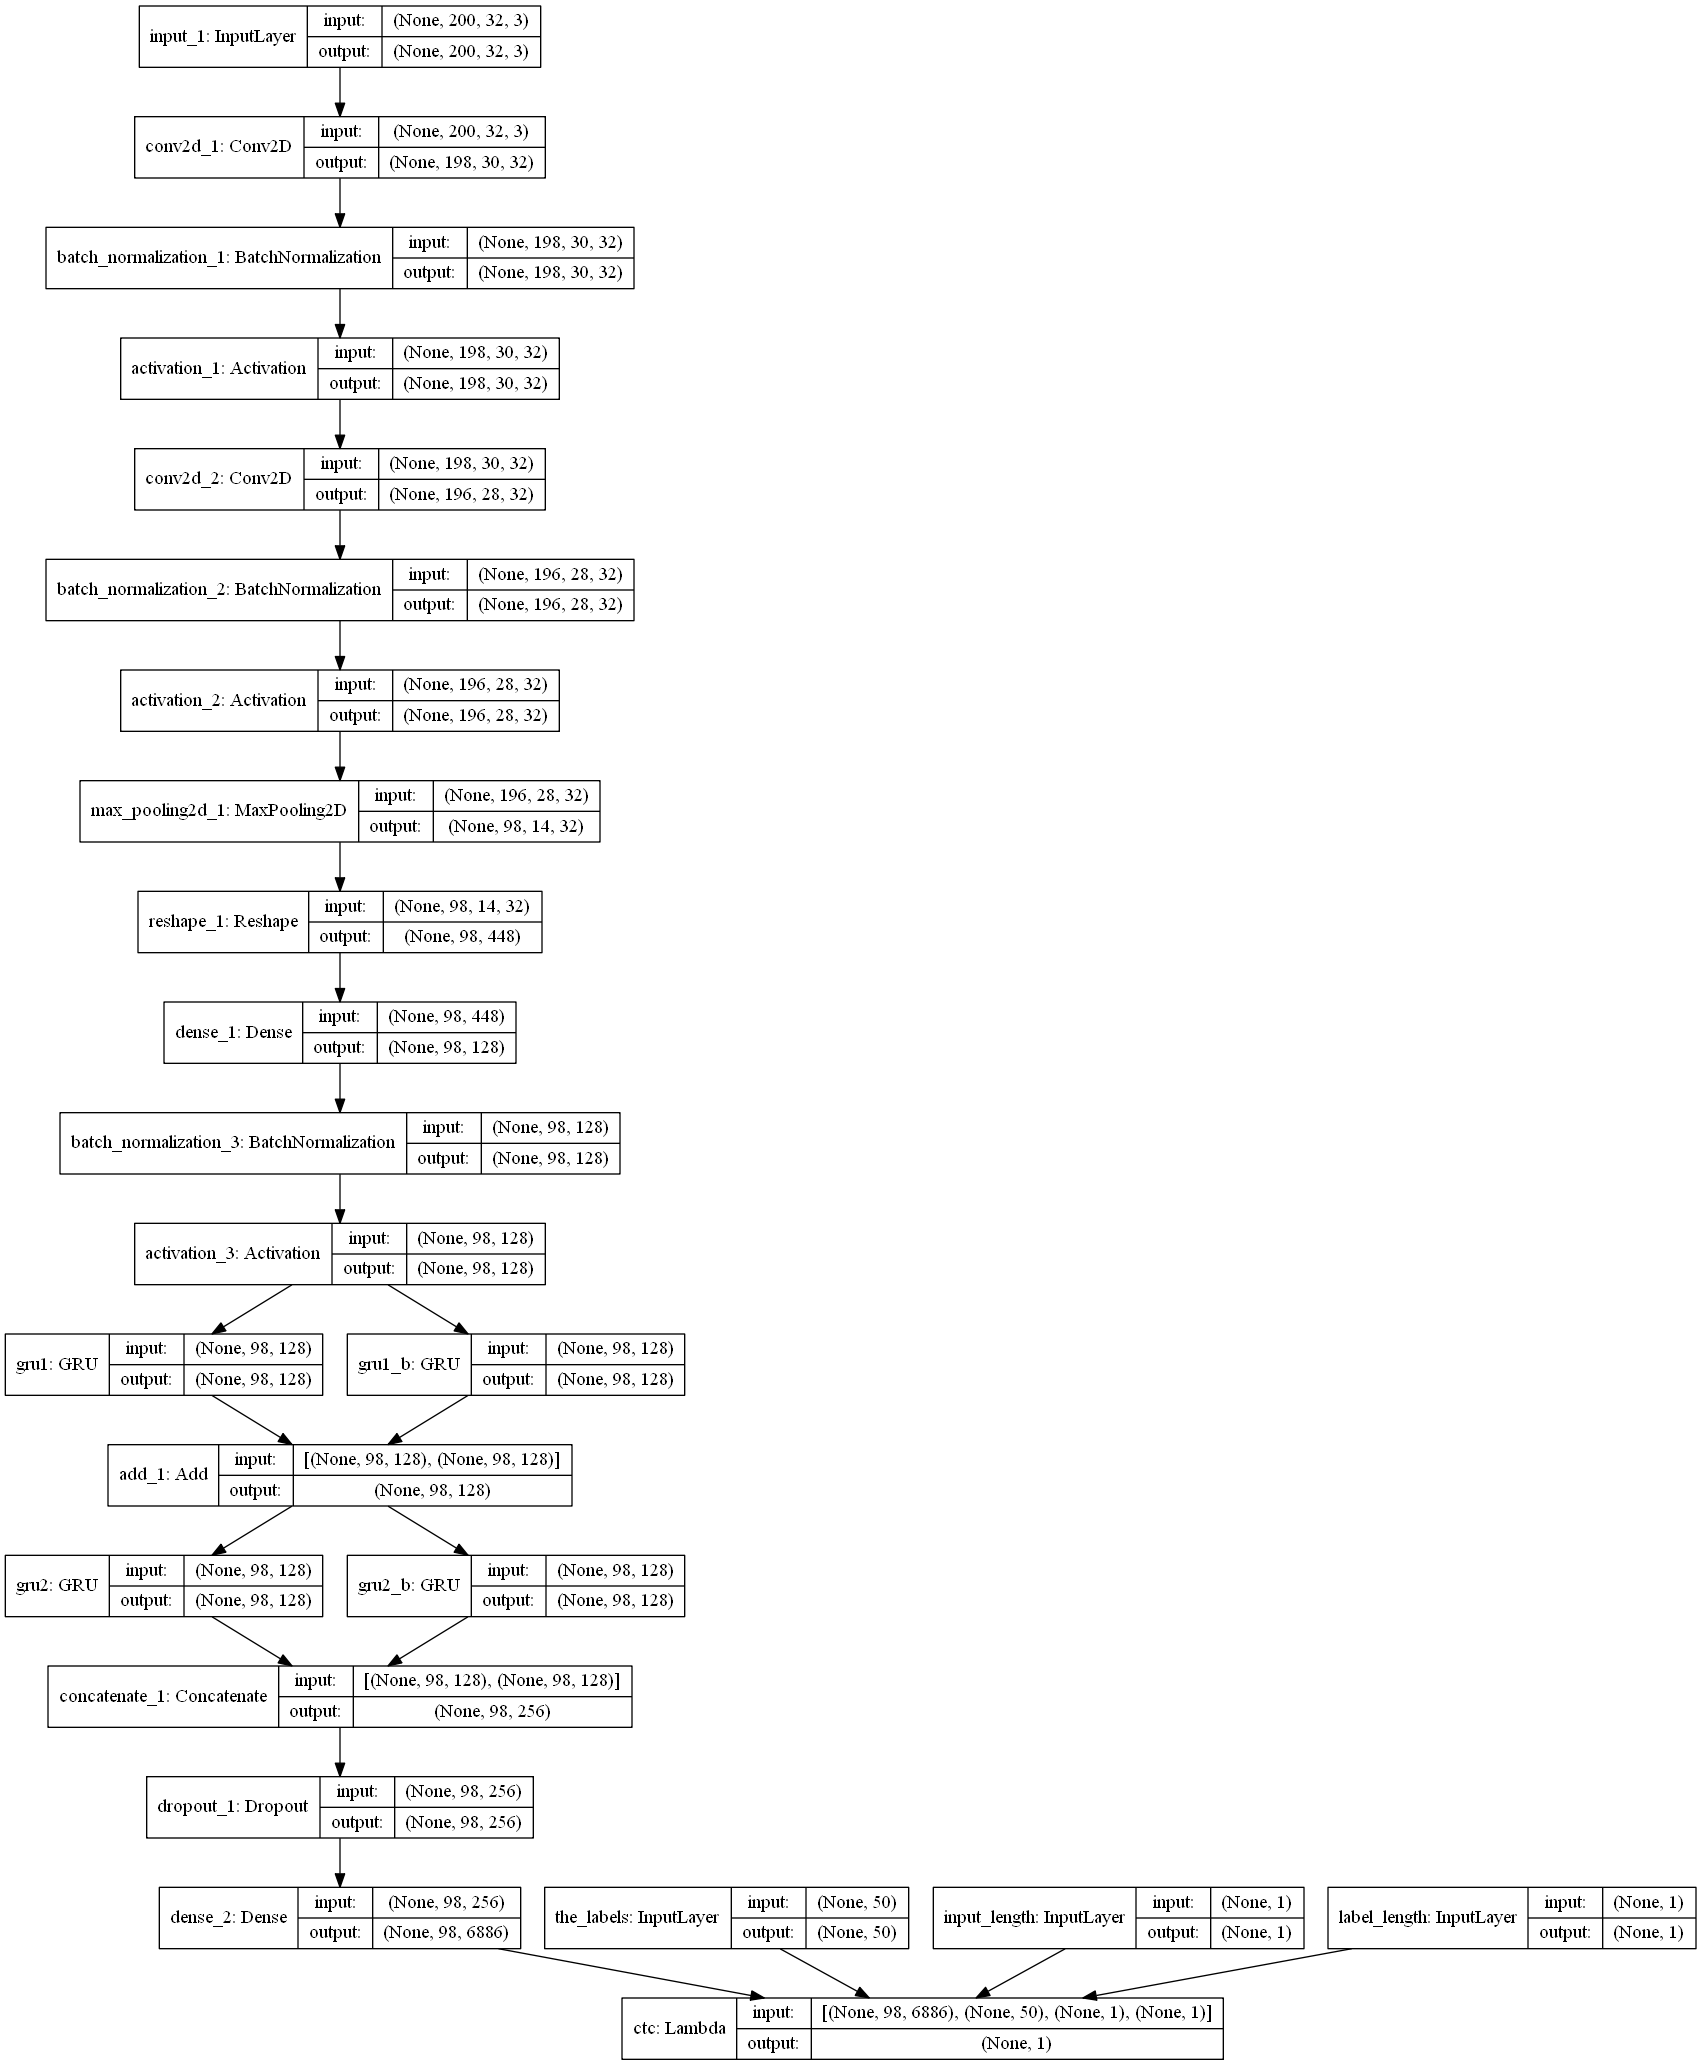

In [6]:
#from keras.utils.visualize_util import plot
from IPython.display import Image
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

#plot(model, to_file="model.png", show_shapes=True)
Image('model.png')

# 定义数据生成器

In [7]:
def readfile(filename):
    res = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        for i in lines:
            res.append(i.strip())
    dic = {}
    for i in res:
        p = i.split(' ')
        dic[p[0]] = p[1:]
    return dic

In [8]:
# #train_data_200_test.txt
# ab = readfile('G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\txt_train_out_v20190616\\train_data_200_test.txt')
# #print(ab)
# #print(train_image_label['TB1M2xKLXXXXXc2XpXXunYpLFXX_21.jpg'])
# #print(len(train_image_label['TB1M2xKLXXXXXc2XpXXunYpLFXX_21.jpg']))
# yyy = np.zeros((1, 200), dtype=np.int32)
# y[0,:len(train_image_label['TB1M2xKLXXXXXc2XpXXunYpLFXX_21.jpg'])] = [int(x) for x in train_image_label['TB1M2xKLXXXXXc2XpXXunYpLFXX_21.jpg']]
# # print([int(x) for x in train_image_label['TB1M2xKLXXXXXc2XpXXunYpLFXX_21.jpg']])
# yyy[0,len(train_image_label['TB1M2xKLXXXXXc2XpXXunYpLFXX_21.jpg']):] = -1
# print(yyy)

In [9]:
train_label_path = 'G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\txt_train_out_v20190616\\train_data_200.txt'
train_image_label = readfile(train_label_path)#image_label[图像名] = char id
_imagefile_train = [i for i, j in train_image_label.items()]#图像名list
count = 0
def gen(train_image_label, _imagefile_train, batch_size=128):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.int32)
    label_length = np.ones(batch_size)
    global count
    while True:
        for i in range(batch_size):
            index = batch_size*count + i
            if index >= len(_imagefile_train):
                count = 0
                index = batch_size*count + i
            img_file_name = _imagefile_train[index]
            char_ids = train_image_label[img_file_name]
#             print('')
#             print(img_file_name)
            img = cv2.imread('G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\image_train_out_v20190616\\%s'%img_file_name)
            X[i] = np.array(img[:,:,::-1]).transpose(1, 0, 2)
            y[i,:len(char_ids)] = [int(x) for x in char_ids]
            y[i,len(char_ids):] = -1
            label_length[i] = len(char_ids)
#         print('')
#         print(count)
        count = count + 1
        #yield [X, y, np.ones(batch_size)*int(conv_shape[1]-2), label_length], np.ones(batch_size)
        yield [X, y, np.ones(batch_size)*int(conv_shape[1]), label_length], np.ones(batch_size)

#[X_test, y_test, _, label_length_test], _  = next(gen(image_label, _imagefile, 1))
#plt.imshow(X_test[0].transpose(1, 0, 2))
#print(y_test)
#plt.title(''.join([id_to_char[x] for x in y_test[0]]))

In [10]:
# for i in range(len(_imagefile_train)):
#     if _imagefile_train[i]=='T1qiJGXyXfXXXXXXXX_!!0-item_pic.jpg_2.jpg':
#         print(i)
#         break

In [11]:
# bat_size=256
# X = np.zeros((bat_size, width, height, 3), dtype=np.uint8)
# y = np.zeros((bat_size, 50), dtype=np.int32)
# label_length = np.ones(bat_size)
# for i in range(bat_size):
#     index = bat_size*35 + i
#     img_file_name = _imagefile_train[index]
#     print(img_file_name)
#     char_ids = train_image_label[img_file_name]
#     print(char_ids)
# #     print('')
# #     print(img_file_name)
#     img = cv2.imread('G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\image_train_out_v20190616\\%s'%img_file_name)
#     X[i] = np.array(img[:,:,::-1]).transpose(1, 0, 2)
#     y[i,:len(char_ids)] = [int(x) for x in char_ids]
#     y[i,len(char_ids):] = -1
#     print(i)
#     label_length[i] = len(char_ids)

In [12]:
# print(y[8,:])
# print(label_length[8])
# print(''.join([id_to_char[x] for x in y[8,:]]))

# 验证函数和回调函数

In [13]:
from tqdm import tqdm
import pandas as pd
import cv2
test_label_path = 'G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\txt_train_out_v20190616\\test_data.txt'
test_image_label = readfile(test_label_path)#image_label[图像名] = char id
_imagefile_test = [i for i, j in test_image_label.items()]#图像名list
#df = pd.read_csv('G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\txt_train_out_v1\\data.txt', sep=' ', header=None)
n_test = 19570
X_test = np.zeros((n_test, width, height, 3), dtype=np.uint8)
y_test = np.zeros((n_test, n_len), dtype=np.int32)
label_length_test = np.zeros((n_test, 1), dtype=np.int32)

for i,item in tqdm(enumerate(_imagefile_test)):
    img = cv2.imread('G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\image_train_out_v20190616\\%s'%item)
    X_test[i] = img[:,:,::-1].transpose(1, 0, 2)#将图像逆时针旋转90度后，上下翻转
    random_str = test_image_label[item]
    y_test[i,:len(random_str)] = [int(x) for x in random_str]
    y_test[i,len(random_str):] = -1
    label_length_test[i] = len(random_str)

19570it [00:04, 4502.62it/s]


In [14]:
# def evaluate(model):
#     y_pred = base_model.predict(X_test, batch_size=16)
#     shape = y_pred[:,2:,:].shape
#     out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :n_len]
#     if out.shape[1] > 4:
#         return (y_test == out).all(axis=-1).mean()
#     return 0

In [15]:
# from keras.callbacks import *

# class Evaluate(Callback):
#     def __init__(self):
#         self.accs = []
    
#     def on_epoch_end(self, epoch, logs=None):
#         acc = evaluate(base_model)*100
#         self.accs.append(acc)
#         print
#         print('val_acc: %f%%'%acc)

# evaluator = Evaluate()

# 训练

In [16]:
from keras.optimizers import *
from keras.callbacks import *

batch_size = 32
#compile的时候，直接将loss设置为y_pred（因为模型的输出就是loss，所以y_pred就是loss），
#无视y_true，训练的时候，y_true随便扔一个符合形状的数组进去就行了
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-3))#lr先设成Adam(1e-3)快速试错，看能否收敛#optimizer=Adam(1e-4))
h = model.fit_generator(gen(train_image_label, _imagefile_train,batch_size), 
                        #pickle_safe=True, workers=12, 
                        #workers=1,
                        use_multiprocessing=False,
                        #validation_data=([X_test, y_test, np.ones(n_test)*int(conv_shape[1]-2), label_length_test], np.ones(n_test)), 
                        validation_data=([X_test, y_test, np.ones(n_test)*int(conv_shape[1]), label_length_test], np.ones(n_test)), 
                        steps_per_epoch=78276/batch_size, epochs=1, #调试只设1代，正常50到150
                        callbacks=[ReduceLROnPlateau('loss'), ModelCheckpoint('model_gru_best.h5', save_best_only=True)]
                       )

Epoch 1/1


 291/2446 [==>...........................] - ETA: 2:05:52 - loss: 815.31 - ETA: 1:14:12 - loss: 765.20 - ETA: 57:00 - loss: 707.2416 - ETA: 48:18 - loss: 642.50 - ETA: 43:26 - loss: 573.33 - ETA: 39:52 - loss: 506.46 - ETA: 37:35 - loss: 448.00 - ETA: 35:41 - loss: 398.09 - ETA: 34:12 - loss: 358.10 - ETA: 32:59 - loss: 325.49 - ETA: 31:59 - loss: 298.58 - ETA: 31:18 - loss: 276.86 - ETA: 30:36 - loss: 258.58 - ETA: 29:57 - loss: 242.83 - ETA: 29:26 - loss: 228.76 - ETA: 28:59 - loss: 216.74 - ETA: 28:36 - loss: 206.16 - ETA: 28:13 - loss: 196.72 - ETA: 28:00 - loss: 188.52 - ETA: 27:46 - loss: 180.65 - ETA: 27:29 - loss: 174.13 - ETA: 27:14 - loss: 167.72 - ETA: 27:02 - loss: 161.91 - ETA: 26:49 - loss: 156.56 - ETA: 26:37 - loss: 151.61 - ETA: 26:26 - loss: 146.90 - ETA: 26:16 - loss: 142.82 - ETA: 26:06 - loss: 138.91 - ETA: 25:57 - loss: 135.23 - ETA: 25:48 - loss: 131.90 - ETA: 25:41 - loss: 128.73 - ETA: 25:33 - loss: 125.62 - ETA: 25:27 - loss: 122.64 - ETA: 25:21 - loss: 119.93

 583/2446 [======>.......................] - ETA: 20:17 - loss: 36.592 - ETA: 20:16 - loss: 36.556 - ETA: 20:16 - loss: 36.528 - ETA: 20:15 - loss: 36.479 - ETA: 20:14 - loss: 36.441 - ETA: 20:14 - loss: 36.398 - ETA: 20:13 - loss: 36.361 - ETA: 20:12 - loss: 36.327 - ETA: 20:12 - loss: 36.273 - ETA: 20:11 - loss: 36.238 - ETA: 20:11 - loss: 36.202 - ETA: 20:10 - loss: 36.169 - ETA: 20:09 - loss: 36.137 - ETA: 20:09 - loss: 36.111 - ETA: 20:08 - loss: 36.090 - ETA: 20:07 - loss: 36.057 - ETA: 20:07 - loss: 36.021 - ETA: 20:06 - loss: 35.985 - ETA: 20:05 - loss: 35.962 - ETA: 20:05 - loss: 35.941 - ETA: 20:04 - loss: 35.911 - ETA: 20:03 - loss: 35.891 - ETA: 20:03 - loss: 35.855 - ETA: 20:02 - loss: 35.824 - ETA: 20:02 - loss: 35.786 - ETA: 20:01 - loss: 35.745 - ETA: 20:00 - loss: 35.710 - ETA: 20:00 - loss: 35.679 - ETA: 19:59 - loss: 35.650 - ETA: 19:59 - loss: 35.625 - ETA: 19:58 - loss: 35.587 - ETA: 19:57 - loss: 35.556 - ETA: 19:56 - loss: 35.518 - ETA: 19:56 - loss: 35.483 - ETA

 875/2446 [=========>....................] - ETA: 17:23 - loss: 30.706 - ETA: 17:22 - loss: 30.698 - ETA: 17:22 - loss: 30.692 - ETA: 17:21 - loss: 30.680 - ETA: 17:20 - loss: 30.669 - ETA: 17:20 - loss: 30.659 - ETA: 17:19 - loss: 30.653 - ETA: 17:19 - loss: 30.641 - ETA: 17:18 - loss: 30.628 - ETA: 17:18 - loss: 30.614 - ETA: 17:17 - loss: 30.616 - ETA: 17:16 - loss: 30.602 - ETA: 17:16 - loss: 30.592 - ETA: 17:15 - loss: 30.580 - ETA: 17:15 - loss: 30.569 - ETA: 17:14 - loss: 30.561 - ETA: 17:13 - loss: 30.557 - ETA: 17:13 - loss: 30.541 - ETA: 17:12 - loss: 30.525 - ETA: 17:12 - loss: 30.513 - ETA: 17:11 - loss: 30.504 - ETA: 17:11 - loss: 30.492 - ETA: 17:10 - loss: 30.478 - ETA: 17:09 - loss: 30.464 - ETA: 17:09 - loss: 30.446 - ETA: 17:08 - loss: 30.429 - ETA: 17:08 - loss: 30.426 - ETA: 17:07 - loss: 30.409 - ETA: 17:07 - loss: 30.394 - ETA: 17:06 - loss: 30.381 - ETA: 17:05 - loss: 30.370 - ETA: 17:05 - loss: 30.355 - ETA: 17:04 - loss: 30.347 - ETA: 17:04 - loss: 30.339 - ETA

1167/2446 [=============>................] - ETA: 14:38 - loss: 28.451 - ETA: 14:38 - loss: 28.447 - ETA: 14:37 - loss: 28.441 - ETA: 14:37 - loss: 28.434 - ETA: 14:36 - loss: 28.428 - ETA: 14:35 - loss: 28.419 - ETA: 14:35 - loss: 28.413 - ETA: 14:34 - loss: 28.408 - ETA: 14:34 - loss: 28.400 - ETA: 14:33 - loss: 28.393 - ETA: 14:33 - loss: 28.384 - ETA: 14:32 - loss: 28.376 - ETA: 14:31 - loss: 28.370 - ETA: 14:31 - loss: 28.367 - ETA: 14:30 - loss: 28.366 - ETA: 14:30 - loss: 28.365 - ETA: 14:29 - loss: 28.358 - ETA: 14:29 - loss: 28.357 - ETA: 14:28 - loss: 28.350 - ETA: 14:28 - loss: 28.345 - ETA: 14:27 - loss: 28.340 - ETA: 14:27 - loss: 28.337 - ETA: 14:26 - loss: 28.332 - ETA: 14:25 - loss: 28.327 - ETA: 14:25 - loss: 28.320 - ETA: 14:24 - loss: 28.317 - ETA: 14:24 - loss: 28.307 - ETA: 14:23 - loss: 28.301 - ETA: 14:23 - loss: 28.300 - ETA: 14:22 - loss: 28.293 - ETA: 14:21 - loss: 28.285 - ETA: 14:21 - loss: 28.280 - ETA: 14:20 - loss: 28.273 - ETA: 14:20 - loss: 28.272 - ETA

1465/2446 [================>.............] - ETA: 11:54 - loss: 27.173 - ETA: 11:54 - loss: 27.172 - ETA: 11:53 - loss: 27.165 - ETA: 11:52 - loss: 27.164 - ETA: 11:52 - loss: 27.158 - ETA: 11:51 - loss: 27.157 - ETA: 11:51 - loss: 27.156 - ETA: 11:50 - loss: 27.153 - ETA: 11:50 - loss: 27.149 - ETA: 11:49 - loss: 27.146 - ETA: 11:49 - loss: 27.144 - ETA: 11:48 - loss: 27.144 - ETA: 11:48 - loss: 27.139 - ETA: 11:47 - loss: 27.136 - ETA: 11:47 - loss: 27.132 - ETA: 11:46 - loss: 27.132 - ETA: 11:45 - loss: 27.131 - ETA: 11:45 - loss: 27.127 - ETA: 11:44 - loss: 27.124 - ETA: 11:44 - loss: 27.117 - ETA: 11:43 - loss: 27.112 - ETA: 11:43 - loss: 27.108 - ETA: 11:42 - loss: 27.106 - ETA: 11:41 - loss: 27.102 - ETA: 11:41 - loss: 27.100 - ETA: 11:40 - loss: 27.098 - ETA: 11:40 - loss: 27.092 - ETA: 11:39 - loss: 27.083 - ETA: 11:39 - loss: 27.079 - ETA: 11:38 - loss: 27.078 - ETA: 11:37 - loss: 27.076 - ETA: 11:37 - loss: 27.075 - ETA: 11:36 - loss: 27.069 - ETA: 11:36 - loss: 27.064 - ETA

1779/2446 [====================>.........] - ETA: 9:07 - loss: 26.29 - ETA: 9:07 - loss: 26.29 - ETA: 9:06 - loss: 26.29 - ETA: 9:06 - loss: 26.29 - ETA: 9:05 - loss: 26.28 - ETA: 9:05 - loss: 26.28 - ETA: 9:04 - loss: 26.28 - ETA: 9:04 - loss: 26.28 - ETA: 9:03 - loss: 26.28 - ETA: 9:02 - loss: 26.27 - ETA: 9:02 - loss: 26.27 - ETA: 9:01 - loss: 26.27 - ETA: 9:01 - loss: 26.27 - ETA: 9:00 - loss: 26.26 - ETA: 9:00 - loss: 26.26 - ETA: 8:59 - loss: 26.26 - ETA: 8:59 - loss: 26.26 - ETA: 8:58 - loss: 26.26 - ETA: 8:57 - loss: 26.25 - ETA: 8:57 - loss: 26.25 - ETA: 8:56 - loss: 26.25 - ETA: 8:56 - loss: 26.25 - ETA: 8:55 - loss: 26.24 - ETA: 8:55 - loss: 26.24 - ETA: 8:54 - loss: 26.24 - ETA: 8:53 - loss: 26.24 - ETA: 8:53 - loss: 26.24 - ETA: 8:52 - loss: 26.24 - ETA: 8:52 - loss: 26.23 - ETA: 8:51 - loss: 26.23 - ETA: 8:51 - loss: 26.23 - ETA: 8:50 - loss: 26.22 - ETA: 8:49 - loss: 26.22 - ETA: 8:49 - loss: 26.22 - ETA: 8:48 - loss: 26.21 - ETA: 8:48 - loss: 26.21 - ETA: 8:47 - loss: 2

2093/2446 [========================>.....] - ETA: 6:12 - loss: 25.62 - ETA: 6:11 - loss: 25.62 - ETA: 6:10 - loss: 25.62 - ETA: 6:10 - loss: 25.62 - ETA: 6:09 - loss: 25.61 - ETA: 6:09 - loss: 25.61 - ETA: 6:08 - loss: 25.61 - ETA: 6:08 - loss: 25.61 - ETA: 6:07 - loss: 25.60 - ETA: 6:07 - loss: 25.60 - ETA: 6:06 - loss: 25.60 - ETA: 6:05 - loss: 25.60 - ETA: 6:05 - loss: 25.60 - ETA: 6:04 - loss: 25.59 - ETA: 6:04 - loss: 25.59 - ETA: 6:03 - loss: 25.59 - ETA: 6:03 - loss: 25.59 - ETA: 6:02 - loss: 25.59 - ETA: 6:01 - loss: 25.58 - ETA: 6:01 - loss: 25.58 - ETA: 6:00 - loss: 25.58 - ETA: 6:00 - loss: 25.58 - ETA: 5:59 - loss: 25.57 - ETA: 5:59 - loss: 25.57 - ETA: 5:58 - loss: 25.57 - ETA: 5:58 - loss: 25.57 - ETA: 5:57 - loss: 25.57 - ETA: 5:56 - loss: 25.57 - ETA: 5:56 - loss: 25.57 - ETA: 5:55 - loss: 25.56 - ETA: 5:55 - loss: 25.56 - ETA: 5:54 - loss: 25.56 - ETA: 5:54 - loss: 25.56 - ETA: 5:53 - loss: 25.56 - ETA: 5:53 - loss: 25.56 - ETA: 5:52 - loss: 25.55 - ETA: 5:51 - loss: 2

2407/2446 [============================>.] - ETA: 3:16 - loss: 25.06 - ETA: 3:15 - loss: 25.06 - ETA: 3:15 - loss: 25.06 - ETA: 3:14 - loss: 25.06 - ETA: 3:14 - loss: 25.06 - ETA: 3:13 - loss: 25.05 - ETA: 3:13 - loss: 25.05 - ETA: 3:12 - loss: 25.05 - ETA: 3:12 - loss: 25.05 - ETA: 3:11 - loss: 25.05 - ETA: 3:10 - loss: 25.04 - ETA: 3:10 - loss: 25.04 - ETA: 3:09 - loss: 25.04 - ETA: 3:09 - loss: 25.04 - ETA: 3:08 - loss: 25.03 - ETA: 3:08 - loss: 25.03 - ETA: 3:07 - loss: 25.03 - ETA: 3:07 - loss: 25.03 - ETA: 3:06 - loss: 25.03 - ETA: 3:05 - loss: 25.03 - ETA: 3:05 - loss: 25.02 - ETA: 3:04 - loss: 25.02 - ETA: 3:04 - loss: 25.02 - ETA: 3:03 - loss: 25.02 - ETA: 3:03 - loss: 25.02 - ETA: 3:02 - loss: 25.02 - ETA: 3:01 - loss: 25.02 - ETA: 3:01 - loss: 25.01 - ETA: 3:00 - loss: 25.01 - ETA: 3:00 - loss: 25.01 - ETA: 2:59 - loss: 25.01 - ETA: 2:59 - loss: 25.01 - ETA: 2:58 - loss: 25.01 - ETA: 2:58 - loss: 25.01 - ETA: 2:57 - loss: 25.01 - ETA: 2:56 - loss: 25.01 - ETA: 2:56 - loss: 2

2447/2446 [==============================] - ETA: 21s - loss: 24.579 - ETA: 20s - loss: 24.579 - ETA: 20s - loss: 24.579 - ETA: 19s - loss: 24.579 - ETA: 19s - loss: 24.577 - ETA: 18s - loss: 24.576 - ETA: 17s - loss: 24.574 - ETA: 17s - loss: 24.573 - ETA: 16s - loss: 24.573 - ETA: 16s - loss: 24.569 - ETA: 15s - loss: 24.568 - ETA: 15s - loss: 24.567 - ETA: 14s - loss: 24.566 - ETA: 14s - loss: 24.564 - ETA: 13s - loss: 24.566 - ETA: 12s - loss: 24.563 - ETA: 12s - loss: 24.563 - ETA: 11s - loss: 24.561 - ETA: 11s - loss: 24.560 - ETA: 10s - loss: 24.559 - ETA: 10s - loss: 24.557 - ETA: 9s - loss: 24.557 - ETA: 8s - loss: 24.55 - ETA: 8s - loss: 24.55 - ETA: 7s - loss: 24.55 - ETA: 7s - loss: 24.55 - ETA: 6s - loss: 24.55 - ETA: 6s - loss: 24.54 - ETA: 5s - loss: 24.54 - ETA: 5s - loss: 24.54 - ETA: 4s - loss: 24.54 - ETA: 3s - loss: 24.54 - ETA: 3s - loss: 24.54 - ETA: 2s - loss: 24.54 - ETA: 2s - loss: 24.54 - ETA: 1s - loss: 24.53 - ETA: 1s - loss: 24.53 - ETA: 0s - loss: 24.53 - 

In [17]:
#model.save('model.h5')

In [19]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-4))
h = model.fit_generator(gen(train_image_label, _imagefile_train,batch_size), 
                        #pickle_safe=True, workers=12, 
                        #workers=1,
                        use_multiprocessing=False,
                        #validation_data=([X_test, y_test, np.ones(n_test)*int(conv_shape[1]-2), label_length_test], np.ones(n_test)), 
                        validation_data=([X_test, y_test, np.ones(n_test)*int(conv_shape[1]), label_length_test], np.ones(n_test)), 
                        steps_per_epoch=78276/batch_size, epochs=1, #调试只设1代，正常50到150
                        callbacks=[ReduceLROnPlateau('loss'), ModelCheckpoint('model_gru_best.h5', save_best_only=True)]
                       )

Epoch 1/1


 291/2446 [==>...........................] - ETA: 55:33 - loss: 21.734 - ETA: 39:33 - loss: 21.618 - ETA: 34:15 - loss: 22.194 - ETA: 31:19 - loss: 21.597 - ETA: 29:39 - loss: 21.357 - ETA: 28:36 - loss: 21.470 - ETA: 27:50 - loss: 21.460 - ETA: 27:08 - loss: 21.618 - ETA: 26:36 - loss: 21.021 - ETA: 26:13 - loss: 21.268 - ETA: 25:52 - loss: 21.105 - ETA: 25:36 - loss: 21.036 - ETA: 25:25 - loss: 21.009 - ETA: 25:19 - loss: 20.808 - ETA: 25:11 - loss: 20.601 - ETA: 25:00 - loss: 20.667 - ETA: 24:50 - loss: 20.718 - ETA: 24:41 - loss: 20.698 - ETA: 24:33 - loss: 20.783 - ETA: 24:30 - loss: 20.964 - ETA: 24:23 - loss: 20.895 - ETA: 24:20 - loss: 20.834 - ETA: 24:14 - loss: 20.832 - ETA: 24:08 - loss: 20.676 - ETA: 24:03 - loss: 20.644 - ETA: 23:59 - loss: 20.602 - ETA: 23:58 - loss: 20.646 - ETA: 23:53 - loss: 20.617 - ETA: 23:49 - loss: 20.537 - ETA: 23:45 - loss: 20.626 - ETA: 23:42 - loss: 20.749 - ETA: 23:39 - loss: 20.694 - ETA: 23:36 - loss: 20.687 - ETA: 23:32 - loss: 20.608 - ETA

 583/2446 [======>.......................] - ETA: 20:20 - loss: 20.336 - ETA: 20:19 - loss: 20.342 - ETA: 20:18 - loss: 20.353 - ETA: 20:18 - loss: 20.365 - ETA: 20:17 - loss: 20.366 - ETA: 20:17 - loss: 20.364 - ETA: 20:16 - loss: 20.361 - ETA: 20:16 - loss: 20.370 - ETA: 20:15 - loss: 20.382 - ETA: 20:14 - loss: 20.389 - ETA: 20:14 - loss: 20.402 - ETA: 20:13 - loss: 20.399 - ETA: 20:13 - loss: 20.401 - ETA: 20:12 - loss: 20.398 - ETA: 20:12 - loss: 20.394 - ETA: 20:11 - loss: 20.394 - ETA: 20:10 - loss: 20.394 - ETA: 20:10 - loss: 20.396 - ETA: 20:09 - loss: 20.401 - ETA: 20:08 - loss: 20.395 - ETA: 20:08 - loss: 20.396 - ETA: 20:07 - loss: 20.393 - ETA: 20:07 - loss: 20.389 - ETA: 20:06 - loss: 20.402 - ETA: 20:05 - loss: 20.398 - ETA: 20:05 - loss: 20.397 - ETA: 20:04 - loss: 20.412 - ETA: 20:04 - loss: 20.408 - ETA: 20:03 - loss: 20.407 - ETA: 20:03 - loss: 20.397 - ETA: 20:02 - loss: 20.391 - ETA: 20:02 - loss: 20.380 - ETA: 20:01 - loss: 20.383 - ETA: 20:00 - loss: 20.372 - ETA

 875/2446 [=========>....................] - ETA: 17:32 - loss: 20.329 - ETA: 17:31 - loss: 20.328 - ETA: 17:31 - loss: 20.329 - ETA: 17:30 - loss: 20.329 - ETA: 17:30 - loss: 20.332 - ETA: 17:29 - loss: 20.337 - ETA: 17:28 - loss: 20.334 - ETA: 17:28 - loss: 20.329 - ETA: 17:27 - loss: 20.327 - ETA: 17:27 - loss: 20.327 - ETA: 17:26 - loss: 20.325 - ETA: 17:26 - loss: 20.322 - ETA: 17:25 - loss: 20.319 - ETA: 17:24 - loss: 20.312 - ETA: 17:24 - loss: 20.307 - ETA: 17:23 - loss: 20.313 - ETA: 17:23 - loss: 20.306 - ETA: 17:22 - loss: 20.301 - ETA: 17:22 - loss: 20.298 - ETA: 17:21 - loss: 20.297 - ETA: 17:21 - loss: 20.292 - ETA: 17:20 - loss: 20.292 - ETA: 17:19 - loss: 20.295 - ETA: 17:19 - loss: 20.295 - ETA: 17:18 - loss: 20.297 - ETA: 17:18 - loss: 20.296 - ETA: 17:17 - loss: 20.305 - ETA: 17:17 - loss: 20.304 - ETA: 17:16 - loss: 20.306 - ETA: 17:16 - loss: 20.307 - ETA: 17:15 - loss: 20.307 - ETA: 17:14 - loss: 20.306 - ETA: 17:14 - loss: 20.305 - ETA: 17:13 - loss: 20.311 - ETA

1167/2446 [=============>................] - ETA: 14:45 - loss: 20.197 - ETA: 14:45 - loss: 20.196 - ETA: 14:44 - loss: 20.200 - ETA: 14:44 - loss: 20.203 - ETA: 14:43 - loss: 20.207 - ETA: 14:42 - loss: 20.205 - ETA: 14:42 - loss: 20.208 - ETA: 14:41 - loss: 20.206 - ETA: 14:41 - loss: 20.207 - ETA: 14:40 - loss: 20.207 - ETA: 14:39 - loss: 20.209 - ETA: 14:39 - loss: 20.210 - ETA: 14:38 - loss: 20.208 - ETA: 14:38 - loss: 20.207 - ETA: 14:37 - loss: 20.208 - ETA: 14:37 - loss: 20.203 - ETA: 14:36 - loss: 20.201 - ETA: 14:36 - loss: 20.206 - ETA: 14:35 - loss: 20.205 - ETA: 14:34 - loss: 20.203 - ETA: 14:34 - loss: 20.206 - ETA: 14:33 - loss: 20.206 - ETA: 14:33 - loss: 20.208 - ETA: 14:32 - loss: 20.205 - ETA: 14:32 - loss: 20.204 - ETA: 14:31 - loss: 20.205 - ETA: 14:31 - loss: 20.204 - ETA: 14:30 - loss: 20.206 - ETA: 14:29 - loss: 20.205 - ETA: 14:29 - loss: 20.205 - ETA: 14:28 - loss: 20.204 - ETA: 14:28 - loss: 20.207 - ETA: 14:27 - loss: 20.207 - ETA: 14:26 - loss: 20.206 - ETA

1464/2446 [================>.............] - ETA: 12:01 - loss: 20.132 - ETA: 12:00 - loss: 20.130 - ETA: 12:00 - loss: 20.129 - ETA: 11:59 - loss: 20.129 - ETA: 11:58 - loss: 20.132 - ETA: 11:58 - loss: 20.134 - ETA: 11:57 - loss: 20.133 - ETA: 11:57 - loss: 20.133 - ETA: 11:56 - loss: 20.129 - ETA: 11:56 - loss: 20.127 - ETA: 11:55 - loss: 20.127 - ETA: 11:54 - loss: 20.129 - ETA: 11:54 - loss: 20.127 - ETA: 11:53 - loss: 20.128 - ETA: 11:53 - loss: 20.129 - ETA: 11:52 - loss: 20.126 - ETA: 11:52 - loss: 20.121 - ETA: 11:51 - loss: 20.122 - ETA: 11:50 - loss: 20.124 - ETA: 11:50 - loss: 20.125 - ETA: 11:49 - loss: 20.128 - ETA: 11:49 - loss: 20.126 - ETA: 11:48 - loss: 20.125 - ETA: 11:48 - loss: 20.126 - ETA: 11:47 - loss: 20.124 - ETA: 11:46 - loss: 20.122 - ETA: 11:46 - loss: 20.121 - ETA: 11:45 - loss: 20.120 - ETA: 11:45 - loss: 20.120 - ETA: 11:44 - loss: 20.117 - ETA: 11:44 - loss: 20.117 - ETA: 11:43 - loss: 20.119 - ETA: 11:42 - loss: 20.119 - ETA: 11:42 - loss: 20.117 - ETA

1778/2446 [====================>.........] - ETA: 9:13 - loss: 20.04 - ETA: 9:12 - loss: 20.04 - ETA: 9:11 - loss: 20.04 - ETA: 9:11 - loss: 20.03 - ETA: 9:10 - loss: 20.03 - ETA: 9:10 - loss: 20.04 - ETA: 9:09 - loss: 20.04 - ETA: 9:09 - loss: 20.04 - ETA: 9:08 - loss: 20.04 - ETA: 9:07 - loss: 20.03 - ETA: 9:07 - loss: 20.03 - ETA: 9:06 - loss: 20.03 - ETA: 9:06 - loss: 20.03 - ETA: 9:05 - loss: 20.04 - ETA: 9:05 - loss: 20.04 - ETA: 9:04 - loss: 20.04 - ETA: 9:03 - loss: 20.04 - ETA: 9:03 - loss: 20.04 - ETA: 9:02 - loss: 20.04 - ETA: 9:02 - loss: 20.03 - ETA: 9:01 - loss: 20.03 - ETA: 9:01 - loss: 20.03 - ETA: 9:00 - loss: 20.03 - ETA: 9:00 - loss: 20.03 - ETA: 8:59 - loss: 20.03 - ETA: 8:58 - loss: 20.03 - ETA: 8:58 - loss: 20.03 - ETA: 8:57 - loss: 20.03 - ETA: 8:57 - loss: 20.03 - ETA: 8:56 - loss: 20.03 - ETA: 8:56 - loss: 20.03 - ETA: 8:55 - loss: 20.02 - ETA: 8:54 - loss: 20.02 - ETA: 8:54 - loss: 20.02 - ETA: 8:53 - loss: 20.02 - ETA: 8:53 - loss: 20.02 - ETA: 8:52 - loss: 2

2092/2446 [========================>.....] - ETA: 6:15 - loss: 19.93 - ETA: 6:15 - loss: 19.93 - ETA: 6:14 - loss: 19.93 - ETA: 6:14 - loss: 19.93 - ETA: 6:13 - loss: 19.93 - ETA: 6:12 - loss: 19.93 - ETA: 6:12 - loss: 19.93 - ETA: 6:11 - loss: 19.93 - ETA: 6:11 - loss: 19.93 - ETA: 6:10 - loss: 19.93 - ETA: 6:10 - loss: 19.92 - ETA: 6:09 - loss: 19.92 - ETA: 6:08 - loss: 19.92 - ETA: 6:08 - loss: 19.92 - ETA: 6:07 - loss: 19.92 - ETA: 6:07 - loss: 19.92 - ETA: 6:06 - loss: 19.93 - ETA: 6:06 - loss: 19.93 - ETA: 6:05 - loss: 19.93 - ETA: 6:05 - loss: 19.92 - ETA: 6:04 - loss: 19.92 - ETA: 6:03 - loss: 19.92 - ETA: 6:03 - loss: 19.92 - ETA: 6:02 - loss: 19.92 - ETA: 6:02 - loss: 19.92 - ETA: 6:01 - loss: 19.92 - ETA: 6:01 - loss: 19.92 - ETA: 6:00 - loss: 19.92 - ETA: 5:59 - loss: 19.92 - ETA: 5:59 - loss: 19.92 - ETA: 5:58 - loss: 19.92 - ETA: 5:58 - loss: 19.92 - ETA: 5:57 - loss: 19.92 - ETA: 5:57 - loss: 19.92 - ETA: 5:56 - loss: 19.92 - ETA: 5:56 - loss: 19.92 - ETA: 5:55 - loss: 1

2406/2446 [============================>.] - ETA: 3:18 - loss: 19.81 - ETA: 3:18 - loss: 19.80 - ETA: 3:17 - loss: 19.80 - ETA: 3:17 - loss: 19.80 - ETA: 3:16 - loss: 19.80 - ETA: 3:16 - loss: 19.80 - ETA: 3:15 - loss: 19.80 - ETA: 3:14 - loss: 19.80 - ETA: 3:14 - loss: 19.80 - ETA: 3:13 - loss: 19.80 - ETA: 3:13 - loss: 19.80 - ETA: 3:12 - loss: 19.80 - ETA: 3:12 - loss: 19.80 - ETA: 3:11 - loss: 19.80 - ETA: 3:10 - loss: 19.80 - ETA: 3:10 - loss: 19.80 - ETA: 3:09 - loss: 19.80 - ETA: 3:09 - loss: 19.80 - ETA: 3:08 - loss: 19.80 - ETA: 3:08 - loss: 19.80 - ETA: 3:07 - loss: 19.80 - ETA: 3:07 - loss: 19.80 - ETA: 3:06 - loss: 19.80 - ETA: 3:05 - loss: 19.80 - ETA: 3:05 - loss: 19.80 - ETA: 3:04 - loss: 19.80 - ETA: 3:04 - loss: 19.80 - ETA: 3:03 - loss: 19.80 - ETA: 3:03 - loss: 19.80 - ETA: 3:02 - loss: 19.80 - ETA: 3:01 - loss: 19.80 - ETA: 3:01 - loss: 19.80 - ETA: 3:00 - loss: 19.80 - ETA: 3:00 - loss: 19.80 - ETA: 2:59 - loss: 19.80 - ETA: 2:59 - loss: 19.80 - ETA: 2:58 - loss: 1

2447/2446 [==============================] - ETA: 22s - loss: 19.689 - ETA: 21s - loss: 19.690 - ETA: 20s - loss: 19.690 - ETA: 20s - loss: 19.690 - ETA: 19s - loss: 19.692 - ETA: 19s - loss: 19.690 - ETA: 18s - loss: 19.690 - ETA: 18s - loss: 19.690 - ETA: 17s - loss: 19.689 - ETA: 16s - loss: 19.689 - ETA: 16s - loss: 19.689 - ETA: 15s - loss: 19.690 - ETA: 15s - loss: 19.690 - ETA: 14s - loss: 19.691 - ETA: 14s - loss: 19.690 - ETA: 13s - loss: 19.689 - ETA: 13s - loss: 19.688 - ETA: 12s - loss: 19.688 - ETA: 11s - loss: 19.688 - ETA: 11s - loss: 19.688 - ETA: 10s - loss: 19.688 - ETA: 10s - loss: 19.689 - ETA: 9s - loss: 19.689 - ETA: 9s - loss: 19.68 - ETA: 8s - loss: 19.68 - ETA: 7s - loss: 19.68 - ETA: 7s - loss: 19.68 - ETA: 6s - loss: 19.68 - ETA: 6s - loss: 19.68 - ETA: 5s - loss: 19.68 - ETA: 5s - loss: 19.68 - ETA: 4s - loss: 19.68 - ETA: 4s - loss: 19.68 - ETA: 3s - loss: 19.68 - ETA: 2s - loss: 19.68 - ETA: 2s - loss: 19.68 - ETA: 1s - loss: 19.68 - ETA: 1s - loss: 19.68 

In [48]:
model.save('model1111.h5')
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-3))
h = model.fit_generator(gen(train_image_label, _imagefile_train,batch_size), 
                        #pickle_safe=True, workers=12, 
                        #workers=1,
                        use_multiprocessing=False,
                        #validation_data=([X_test, y_test, np.ones(n_test)*int(conv_shape[1]-2), label_length_test], np.ones(n_test)), 
                        validation_data=([X_test, y_test, np.ones(n_test)*int(conv_shape[1]), label_length_test], np.ones(n_test)), 
                        steps_per_epoch=78276/batch_size, epochs=5, #调试只设1代，正常50到150
                        callbacks=[ReduceLROnPlateau('loss'), ModelCheckpoint('model_gru_best.h5', save_best_only=True)]
                       )
model.save('model.h5')

Epoch 1/5


 291/2446 [==>...........................] - ETA: 1:05:21 - loss: 18.531 - ETA: 44:58 - loss: 17.9042  - ETA: 37:25 - loss: 17.338 - ETA: 33:42 - loss: 17.037 - ETA: 31:44 - loss: 17.731 - ETA: 30:13 - loss: 18.329 - ETA: 29:09 - loss: 18.545 - ETA: 28:23 - loss: 18.832 - ETA: 27:46 - loss: 19.320 - ETA: 27:18 - loss: 19.192 - ETA: 26:53 - loss: 19.169 - ETA: 26:30 - loss: 19.289 - ETA: 26:12 - loss: 19.121 - ETA: 25:55 - loss: 19.121 - ETA: 25:43 - loss: 19.101 - ETA: 25:32 - loss: 19.179 - ETA: 25:22 - loss: 19.175 - ETA: 25:12 - loss: 19.100 - ETA: 25:02 - loss: 19.253 - ETA: 24:54 - loss: 19.467 - ETA: 24:49 - loss: 19.418 - ETA: 24:45 - loss: 19.512 - ETA: 24:42 - loss: 19.386 - ETA: 24:36 - loss: 19.349 - ETA: 24:32 - loss: 19.342 - ETA: 24:26 - loss: 19.351 - ETA: 24:23 - loss: 19.486 - ETA: 24:19 - loss: 19.449 - ETA: 24:15 - loss: 19.466 - ETA: 24:13 - loss: 19.488 - ETA: 24:09 - loss: 19.532 - ETA: 24:05 - loss: 19.573 - ETA: 24:02 - loss: 19.624 - ETA: 23:59 - loss: 19.620 -

 583/2446 [======>.......................] - ETA: 20:26 - loss: 19.432 - ETA: 20:26 - loss: 19.436 - ETA: 20:25 - loss: 19.432 - ETA: 20:24 - loss: 19.427 - ETA: 20:24 - loss: 19.428 - ETA: 20:23 - loss: 19.429 - ETA: 20:22 - loss: 19.431 - ETA: 20:22 - loss: 19.434 - ETA: 20:21 - loss: 19.425 - ETA: 20:21 - loss: 19.426 - ETA: 20:20 - loss: 19.425 - ETA: 20:19 - loss: 19.419 - ETA: 20:19 - loss: 19.433 - ETA: 20:18 - loss: 19.430 - ETA: 20:17 - loss: 19.427 - ETA: 20:17 - loss: 19.443 - ETA: 20:16 - loss: 19.435 - ETA: 20:16 - loss: 19.433 - ETA: 20:15 - loss: 19.424 - ETA: 20:14 - loss: 19.417 - ETA: 20:14 - loss: 19.403 - ETA: 20:13 - loss: 19.405 - ETA: 20:13 - loss: 19.394 - ETA: 20:12 - loss: 19.386 - ETA: 20:11 - loss: 19.380 - ETA: 20:11 - loss: 19.376 - ETA: 20:10 - loss: 19.368 - ETA: 20:10 - loss: 19.357 - ETA: 20:09 - loss: 19.361 - ETA: 20:09 - loss: 19.360 - ETA: 20:08 - loss: 19.363 - ETA: 20:07 - loss: 19.365 - ETA: 20:07 - loss: 19.365 - ETA: 20:06 - loss: 19.363 - ETA

 875/2446 [=========>....................] - ETA: 17:33 - loss: 18.748 - ETA: 17:33 - loss: 18.745 - ETA: 17:32 - loss: 18.737 - ETA: 17:32 - loss: 18.732 - ETA: 17:31 - loss: 18.736 - ETA: 17:30 - loss: 18.728 - ETA: 17:30 - loss: 18.721 - ETA: 17:29 - loss: 18.716 - ETA: 17:29 - loss: 18.712 - ETA: 17:28 - loss: 18.705 - ETA: 17:27 - loss: 18.703 - ETA: 17:27 - loss: 18.702 - ETA: 17:26 - loss: 18.700 - ETA: 17:26 - loss: 18.699 - ETA: 17:25 - loss: 18.693 - ETA: 17:25 - loss: 18.697 - ETA: 17:24 - loss: 18.693 - ETA: 17:23 - loss: 18.691 - ETA: 17:23 - loss: 18.690 - ETA: 17:22 - loss: 18.685 - ETA: 17:21 - loss: 18.683 - ETA: 17:21 - loss: 18.681 - ETA: 17:20 - loss: 18.685 - ETA: 17:20 - loss: 18.685 - ETA: 17:19 - loss: 18.676 - ETA: 17:19 - loss: 18.678 - ETA: 17:18 - loss: 18.677 - ETA: 17:17 - loss: 18.681 - ETA: 17:17 - loss: 18.679 - ETA: 17:16 - loss: 18.675 - ETA: 17:16 - loss: 18.678 - ETA: 17:15 - loss: 18.675 - ETA: 17:14 - loss: 18.678 - ETA: 17:14 - loss: 18.674 - ETA

1167/2446 [=============>................] - ETA: 14:45 - loss: 17.950 - ETA: 14:44 - loss: 17.945 - ETA: 14:43 - loss: 17.941 - ETA: 14:43 - loss: 17.940 - ETA: 14:42 - loss: 17.933 - ETA: 14:42 - loss: 17.931 - ETA: 14:41 - loss: 17.932 - ETA: 14:41 - loss: 17.928 - ETA: 14:40 - loss: 17.926 - ETA: 14:39 - loss: 17.926 - ETA: 14:39 - loss: 17.924 - ETA: 14:38 - loss: 17.923 - ETA: 14:38 - loss: 17.917 - ETA: 14:37 - loss: 17.916 - ETA: 14:37 - loss: 17.914 - ETA: 14:36 - loss: 17.910 - ETA: 14:35 - loss: 17.909 - ETA: 14:35 - loss: 17.906 - ETA: 14:34 - loss: 17.905 - ETA: 14:34 - loss: 17.900 - ETA: 14:33 - loss: 17.899 - ETA: 14:33 - loss: 17.898 - ETA: 14:32 - loss: 17.894 - ETA: 14:31 - loss: 17.890 - ETA: 14:31 - loss: 17.887 - ETA: 14:30 - loss: 17.887 - ETA: 14:30 - loss: 17.884 - ETA: 14:29 - loss: 17.883 - ETA: 14:28 - loss: 17.878 - ETA: 14:28 - loss: 17.873 - ETA: 14:27 - loss: 17.873 - ETA: 14:27 - loss: 17.868 - ETA: 14:26 - loss: 17.863 - ETA: 14:26 - loss: 17.860 - ETA

1465/2446 [================>.............] - ETA: 11:58 - loss: 17.243 - ETA: 11:58 - loss: 17.239 - ETA: 11:57 - loss: 17.236 - ETA: 11:57 - loss: 17.235 - ETA: 11:56 - loss: 17.230 - ETA: 11:56 - loss: 17.225 - ETA: 11:55 - loss: 17.223 - ETA: 11:54 - loss: 17.221 - ETA: 11:54 - loss: 17.220 - ETA: 11:53 - loss: 17.223 - ETA: 11:53 - loss: 17.220 - ETA: 11:52 - loss: 17.218 - ETA: 11:52 - loss: 17.217 - ETA: 11:51 - loss: 17.213 - ETA: 11:50 - loss: 17.209 - ETA: 11:50 - loss: 17.207 - ETA: 11:49 - loss: 17.205 - ETA: 11:49 - loss: 17.202 - ETA: 11:48 - loss: 17.198 - ETA: 11:48 - loss: 17.196 - ETA: 11:47 - loss: 17.196 - ETA: 11:47 - loss: 17.193 - ETA: 11:46 - loss: 17.189 - ETA: 11:45 - loss: 17.187 - ETA: 11:45 - loss: 17.181 - ETA: 11:44 - loss: 17.177 - ETA: 11:44 - loss: 17.175 - ETA: 11:43 - loss: 17.172 - ETA: 11:43 - loss: 17.173 - ETA: 11:42 - loss: 17.171 - ETA: 11:42 - loss: 17.169 - ETA: 11:41 - loss: 17.166 - ETA: 11:40 - loss: 17.165 - ETA: 11:40 - loss: 17.162 - ETA

1779/2446 [====================>.........] - ETA: 9:10 - loss: 16.59 - ETA: 9:10 - loss: 16.59 - ETA: 9:09 - loss: 16.59 - ETA: 9:08 - loss: 16.59 - ETA: 9:08 - loss: 16.59 - ETA: 9:07 - loss: 16.59 - ETA: 9:07 - loss: 16.58 - ETA: 9:06 - loss: 16.58 - ETA: 9:06 - loss: 16.58 - ETA: 9:05 - loss: 16.58 - ETA: 9:04 - loss: 16.57 - ETA: 9:04 - loss: 16.57 - ETA: 9:03 - loss: 16.57 - ETA: 9:03 - loss: 16.56 - ETA: 9:02 - loss: 16.56 - ETA: 9:02 - loss: 16.56 - ETA: 9:01 - loss: 16.56 - ETA: 9:00 - loss: 16.56 - ETA: 9:00 - loss: 16.55 - ETA: 8:59 - loss: 16.55 - ETA: 8:59 - loss: 16.55 - ETA: 8:58 - loss: 16.55 - ETA: 8:58 - loss: 16.55 - ETA: 8:57 - loss: 16.54 - ETA: 8:56 - loss: 16.54 - ETA: 8:56 - loss: 16.54 - ETA: 8:55 - loss: 16.54 - ETA: 8:55 - loss: 16.54 - ETA: 8:54 - loss: 16.54 - ETA: 8:54 - loss: 16.54 - ETA: 8:53 - loss: 16.54 - ETA: 8:53 - loss: 16.53 - ETA: 8:52 - loss: 16.53 - ETA: 8:51 - loss: 16.54 - ETA: 8:51 - loss: 16.54 - ETA: 8:50 - loss: 16.53 - ETA: 8:50 - loss: 1

2093/2446 [========================>.....] - ETA: 6:13 - loss: 15.98 - ETA: 6:13 - loss: 15.98 - ETA: 6:12 - loss: 15.97 - ETA: 6:11 - loss: 15.97 - ETA: 6:11 - loss: 15.97 - ETA: 6:10 - loss: 15.97 - ETA: 6:10 - loss: 15.97 - ETA: 6:09 - loss: 15.97 - ETA: 6:09 - loss: 15.97 - ETA: 6:08 - loss: 15.97 - ETA: 6:08 - loss: 15.96 - ETA: 6:07 - loss: 15.96 - ETA: 6:06 - loss: 15.96 - ETA: 6:06 - loss: 15.96 - ETA: 6:05 - loss: 15.96 - ETA: 6:05 - loss: 15.96 - ETA: 6:04 - loss: 15.95 - ETA: 6:04 - loss: 15.95 - ETA: 6:03 - loss: 15.95 - ETA: 6:03 - loss: 15.95 - ETA: 6:02 - loss: 15.95 - ETA: 6:01 - loss: 15.95 - ETA: 6:01 - loss: 15.95 - ETA: 6:00 - loss: 15.94 - ETA: 6:00 - loss: 15.94 - ETA: 5:59 - loss: 15.94 - ETA: 5:59 - loss: 15.94 - ETA: 5:58 - loss: 15.94 - ETA: 5:57 - loss: 15.93 - ETA: 5:57 - loss: 15.93 - ETA: 5:56 - loss: 15.93 - ETA: 5:56 - loss: 15.93 - ETA: 5:55 - loss: 15.93 - ETA: 5:55 - loss: 15.92 - ETA: 5:54 - loss: 15.92 - ETA: 5:54 - loss: 15.92 - ETA: 5:53 - loss: 1

2407/2446 [============================>.] - ETA: 3:17 - loss: 15.42 - ETA: 3:16 - loss: 15.42 - ETA: 3:16 - loss: 15.42 - ETA: 3:15 - loss: 15.42 - ETA: 3:15 - loss: 15.41 - ETA: 3:14 - loss: 15.41 - ETA: 3:14 - loss: 15.41 - ETA: 3:13 - loss: 15.41 - ETA: 3:12 - loss: 15.41 - ETA: 3:12 - loss: 15.41 - ETA: 3:11 - loss: 15.41 - ETA: 3:11 - loss: 15.41 - ETA: 3:10 - loss: 15.40 - ETA: 3:10 - loss: 15.40 - ETA: 3:09 - loss: 15.40 - ETA: 3:09 - loss: 15.40 - ETA: 3:08 - loss: 15.40 - ETA: 3:07 - loss: 15.40 - ETA: 3:07 - loss: 15.40 - ETA: 3:06 - loss: 15.40 - ETA: 3:06 - loss: 15.39 - ETA: 3:05 - loss: 15.39 - ETA: 3:05 - loss: 15.39 - ETA: 3:04 - loss: 15.39 - ETA: 3:03 - loss: 15.39 - ETA: 3:03 - loss: 15.38 - ETA: 3:02 - loss: 15.38 - ETA: 3:02 - loss: 15.38 - ETA: 3:01 - loss: 15.38 - ETA: 3:01 - loss: 15.37 - ETA: 3:00 - loss: 15.37 - ETA: 3:00 - loss: 15.37 - ETA: 2:59 - loss: 15.37 - ETA: 2:58 - loss: 15.37 - ETA: 2:58 - loss: 15.37 - ETA: 2:57 - loss: 15.37 - ETA: 2:57 - loss: 1

2447/2446 [==============================] - ETA: 21s - loss: 14.931 - ETA: 20s - loss: 14.930 - ETA: 20s - loss: 14.928 - ETA: 19s - loss: 14.926 - ETA: 19s - loss: 14.924 - ETA: 18s - loss: 14.923 - ETA: 18s - loss: 14.922 - ETA: 17s - loss: 14.920 - ETA: 16s - loss: 14.918 - ETA: 16s - loss: 14.918 - ETA: 15s - loss: 14.917 - ETA: 15s - loss: 14.916 - ETA: 14s - loss: 14.913 - ETA: 14s - loss: 14.913 - ETA: 13s - loss: 14.911 - ETA: 12s - loss: 14.910 - ETA: 12s - loss: 14.908 - ETA: 11s - loss: 14.906 - ETA: 11s - loss: 14.906 - ETA: 10s - loss: 14.903 - ETA: 10s - loss: 14.901 - ETA: 9s - loss: 14.899 - ETA: 9s - loss: 14.89 - ETA: 8s - loss: 14.89 - ETA: 7s - loss: 14.89 - ETA: 7s - loss: 14.89 - ETA: 6s - loss: 14.88 - ETA: 6s - loss: 14.88 - ETA: 5s - loss: 14.88 - ETA: 5s - loss: 14.88 - ETA: 4s - loss: 14.88 - ETA: 3s - loss: 14.88 - ETA: 3s - loss: 14.88 - ETA: 2s - loss: 14.87 - ETA: 2s - loss: 14.87 - ETA: 1s - loss: 14.87 - ETA: 1s - loss: 14.87 - ETA: 0s - loss: 14.87 - 

 292/2446 [==>...........................] - ETA: 22:35 - loss: 13.616 - ETA: 22:25 - loss: 10.619 - ETA: 23:02 - loss: 10.595 - ETA: 23:03 - loss: 10.545 - ETA: 23:01 - loss: 11.024 - ETA: 22:57 - loss: 11.201 - ETA: 22:52 - loss: 11.228 - ETA: 22:47 - loss: 11.838 - ETA: 22:44 - loss: 11.350 - ETA: 22:52 - loss: 11.367 - ETA: 22:50 - loss: 11.032 - ETA: 22:49 - loss: 10.866 - ETA: 22:46 - loss: 10.705 - ETA: 22:45 - loss: 10.667 - ETA: 22:47 - loss: 10.674 - ETA: 22:52 - loss: 10.818 - ETA: 22:49 - loss: 10.756 - ETA: 22:46 - loss: 10.724 - ETA: 22:47 - loss: 10.924 - ETA: 22:45 - loss: 10.918 - ETA: 22:43 - loss: 10.835 - ETA: 22:42 - loss: 10.753 - ETA: 22:41 - loss: 10.802 - ETA: 22:40 - loss: 10.835 - ETA: 22:39 - loss: 10.774 - ETA: 22:37 - loss: 10.898 - ETA: 22:36 - loss: 10.843 - ETA: 22:35 - loss: 10.825 - ETA: 22:34 - loss: 10.822 - ETA: 22:34 - loss: 10.863 - ETA: 22:33 - loss: 10.893 - ETA: 22:32 - loss: 10.909 - ETA: 22:31 - loss: 10.925 - ETA: 22:30 - loss: 10.971 - ETA

 584/2446 [======>.......................] - ETA: 20:02 - loss: 10.754 - ETA: 20:01 - loss: 10.759 - ETA: 20:00 - loss: 10.763 - ETA: 20:00 - loss: 10.762 - ETA: 19:59 - loss: 10.759 - ETA: 19:59 - loss: 10.770 - ETA: 19:58 - loss: 10.763 - ETA: 19:57 - loss: 10.756 - ETA: 19:57 - loss: 10.755 - ETA: 19:56 - loss: 10.750 - ETA: 19:56 - loss: 10.769 - ETA: 19:55 - loss: 10.761 - ETA: 19:55 - loss: 10.756 - ETA: 19:54 - loss: 10.771 - ETA: 19:53 - loss: 10.764 - ETA: 19:53 - loss: 10.769 - ETA: 19:52 - loss: 10.766 - ETA: 19:52 - loss: 10.764 - ETA: 19:51 - loss: 10.755 - ETA: 19:51 - loss: 10.755 - ETA: 19:50 - loss: 10.753 - ETA: 19:49 - loss: 10.751 - ETA: 19:49 - loss: 10.747 - ETA: 19:48 - loss: 10.746 - ETA: 19:48 - loss: 10.741 - ETA: 19:47 - loss: 10.731 - ETA: 19:47 - loss: 10.730 - ETA: 19:46 - loss: 10.733 - ETA: 19:46 - loss: 10.733 - ETA: 19:45 - loss: 10.741 - ETA: 19:44 - loss: 10.736 - ETA: 19:44 - loss: 10.729 - ETA: 19:44 - loss: 10.719 - ETA: 19:43 - loss: 10.714 - ETA

 876/2446 [=========>....................] - ETA: 17:19 - loss: 10.566 - ETA: 17:19 - loss: 10.563 - ETA: 17:18 - loss: 10.567 - ETA: 17:18 - loss: 10.563 - ETA: 17:17 - loss: 10.558 - ETA: 17:17 - loss: 10.555 - ETA: 17:16 - loss: 10.556 - ETA: 17:15 - loss: 10.553 - ETA: 17:15 - loss: 10.552 - ETA: 17:14 - loss: 10.553 - ETA: 17:14 - loss: 10.553 - ETA: 17:13 - loss: 10.553 - ETA: 17:13 - loss: 10.548 - ETA: 17:12 - loss: 10.552 - ETA: 17:12 - loss: 10.549 - ETA: 17:11 - loss: 10.550 - ETA: 17:10 - loss: 10.551 - ETA: 17:10 - loss: 10.549 - ETA: 17:09 - loss: 10.547 - ETA: 17:09 - loss: 10.546 - ETA: 17:08 - loss: 10.552 - ETA: 17:08 - loss: 10.555 - ETA: 17:07 - loss: 10.547 - ETA: 17:07 - loss: 10.548 - ETA: 17:06 - loss: 10.548 - ETA: 17:05 - loss: 10.551 - ETA: 17:05 - loss: 10.551 - ETA: 17:04 - loss: 10.545 - ETA: 17:04 - loss: 10.547 - ETA: 17:03 - loss: 10.546 - ETA: 17:03 - loss: 10.549 - ETA: 17:02 - loss: 10.547 - ETA: 17:02 - loss: 10.544 - ETA: 17:01 - loss: 10.540 - ETA

1168/2446 [=============>................] - ETA: 14:37 - loss: 10.357 - ETA: 14:36 - loss: 10.358 - ETA: 14:36 - loss: 10.355 - ETA: 14:35 - loss: 10.355 - ETA: 14:35 - loss: 10.357 - ETA: 14:34 - loss: 10.355 - ETA: 14:34 - loss: 10.355 - ETA: 14:33 - loss: 10.358 - ETA: 14:32 - loss: 10.359 - ETA: 14:32 - loss: 10.359 - ETA: 14:31 - loss: 10.357 - ETA: 14:31 - loss: 10.359 - ETA: 14:30 - loss: 10.365 - ETA: 14:30 - loss: 10.366 - ETA: 14:29 - loss: 10.365 - ETA: 14:29 - loss: 10.364 - ETA: 14:28 - loss: 10.367 - ETA: 14:27 - loss: 10.366 - ETA: 14:27 - loss: 10.365 - ETA: 14:26 - loss: 10.365 - ETA: 14:26 - loss: 10.365 - ETA: 14:25 - loss: 10.362 - ETA: 14:25 - loss: 10.362 - ETA: 14:24 - loss: 10.364 - ETA: 14:23 - loss: 10.362 - ETA: 14:23 - loss: 10.363 - ETA: 14:22 - loss: 10.361 - ETA: 14:22 - loss: 10.358 - ETA: 14:21 - loss: 10.360 - ETA: 14:21 - loss: 10.358 - ETA: 14:20 - loss: 10.356 - ETA: 14:20 - loss: 10.356 - ETA: 14:19 - loss: 10.354 - ETA: 14:18 - loss: 10.353 - ETA

1466/2446 [================>.............] - ETA: 11:54 - loss: 10.192 - ETA: 11:53 - loss: 10.191 - ETA: 11:53 - loss: 10.189 - ETA: 11:52 - loss: 10.188 - ETA: 11:52 - loss: 10.192 - ETA: 11:51 - loss: 10.193 - ETA: 11:50 - loss: 10.194 - ETA: 11:50 - loss: 10.197 - ETA: 11:49 - loss: 10.197 - ETA: 11:49 - loss: 10.196 - ETA: 11:48 - loss: 10.197 - ETA: 11:48 - loss: 10.196 - ETA: 11:47 - loss: 10.194 - ETA: 11:46 - loss: 10.194 - ETA: 11:46 - loss: 10.195 - ETA: 11:45 - loss: 10.194 - ETA: 11:45 - loss: 10.192 - ETA: 11:44 - loss: 10.191 - ETA: 11:44 - loss: 10.192 - ETA: 11:43 - loss: 10.191 - ETA: 11:43 - loss: 10.189 - ETA: 11:42 - loss: 10.190 - ETA: 11:41 - loss: 10.187 - ETA: 11:41 - loss: 10.185 - ETA: 11:40 - loss: 10.185 - ETA: 11:40 - loss: 10.184 - ETA: 11:39 - loss: 10.186 - ETA: 11:39 - loss: 10.185 - ETA: 11:38 - loss: 10.185 - ETA: 11:37 - loss: 10.184 - ETA: 11:37 - loss: 10.184 - ETA: 11:36 - loss: 10.182 - ETA: 11:36 - loss: 10.181 - ETA: 11:35 - loss: 10.179 - ETA

1780/2446 [====================>.........] - ETA: 9:07 - loss: 10.03 - ETA: 9:06 - loss: 10.03 - ETA: 9:06 - loss: 10.03 - ETA: 9:05 - loss: 10.03 - ETA: 9:05 - loss: 10.03 - ETA: 9:04 - loss: 10.03 - ETA: 9:04 - loss: 10.03 - ETA: 9:03 - loss: 10.02 - ETA: 9:03 - loss: 10.02 - ETA: 9:02 - loss: 10.02 - ETA: 9:01 - loss: 10.02 - ETA: 9:01 - loss: 10.02 - ETA: 9:00 - loss: 10.02 - ETA: 9:00 - loss: 10.02 - ETA: 8:59 - loss: 10.02 - ETA: 8:59 - loss: 10.02 - ETA: 8:58 - loss: 10.02 - ETA: 8:58 - loss: 10.01 - ETA: 8:57 - loss: 10.01 - ETA: 8:56 - loss: 10.02 - ETA: 8:56 - loss: 10.02 - ETA: 8:55 - loss: 10.02 - ETA: 8:55 - loss: 10.02 - ETA: 8:54 - loss: 10.01 - ETA: 8:54 - loss: 10.01 - ETA: 8:53 - loss: 10.02 - ETA: 8:53 - loss: 10.02 - ETA: 8:52 - loss: 10.02 - ETA: 8:51 - loss: 10.02 - ETA: 8:51 - loss: 10.02 - ETA: 8:50 - loss: 10.02 - ETA: 8:50 - loss: 10.02 - ETA: 8:49 - loss: 10.02 - ETA: 8:49 - loss: 10.02 - ETA: 8:48 - loss: 10.02 - ETA: 8:48 - loss: 10.02 - ETA: 8:47 - loss: 1

2094/2446 [========================>.....] - ETA: 6:11 - loss: 9.848 - ETA: 6:11 - loss: 9.848 - ETA: 6:10 - loss: 9.849 - ETA: 6:10 - loss: 9.848 - ETA: 6:09 - loss: 9.848 - ETA: 6:09 - loss: 9.848 - ETA: 6:08 - loss: 9.847 - ETA: 6:08 - loss: 9.848 - ETA: 6:07 - loss: 9.847 - ETA: 6:06 - loss: 9.850 - ETA: 6:06 - loss: 9.848 - ETA: 6:05 - loss: 9.848 - ETA: 6:05 - loss: 9.848 - ETA: 6:04 - loss: 9.848 - ETA: 6:04 - loss: 9.847 - ETA: 6:03 - loss: 9.845 - ETA: 6:03 - loss: 9.846 - ETA: 6:02 - loss: 9.846 - ETA: 6:01 - loss: 9.846 - ETA: 6:01 - loss: 9.847 - ETA: 6:00 - loss: 9.846 - ETA: 6:00 - loss: 9.844 - ETA: 5:59 - loss: 9.843 - ETA: 5:59 - loss: 9.844 - ETA: 5:58 - loss: 9.845 - ETA: 5:57 - loss: 9.844 - ETA: 5:57 - loss: 9.843 - ETA: 5:56 - loss: 9.843 - ETA: 5:56 - loss: 9.841 - ETA: 5:55 - loss: 9.841 - ETA: 5:55 - loss: 9.840 - ETA: 5:54 - loss: 9.838 - ETA: 5:54 - loss: 9.838 - ETA: 5:53 - loss: 9.838 - ETA: 5:52 - loss: 9.837 - ETA: 5:52 - loss: 9.835 - ETA: 5:51 - loss: 9

2414/2446 [============================>.] - ETA: 3:16 - loss: 9.696 - ETA: 3:15 - loss: 9.696 - ETA: 3:15 - loss: 9.694 - ETA: 3:14 - loss: 9.694 - ETA: 3:14 - loss: 9.693 - ETA: 3:13 - loss: 9.693 - ETA: 3:12 - loss: 9.694 - ETA: 3:12 - loss: 9.694 - ETA: 3:11 - loss: 9.693 - ETA: 3:11 - loss: 9.694 - ETA: 3:10 - loss: 9.693 - ETA: 3:10 - loss: 9.693 - ETA: 3:09 - loss: 9.691 - ETA: 3:09 - loss: 9.690 - ETA: 3:08 - loss: 9.690 - ETA: 3:07 - loss: 9.691 - ETA: 3:07 - loss: 9.692 - ETA: 3:06 - loss: 9.692 - ETA: 3:06 - loss: 9.690 - ETA: 3:05 - loss: 9.690 - ETA: 3:05 - loss: 9.691 - ETA: 3:04 - loss: 9.690 - ETA: 3:04 - loss: 9.687 - ETA: 3:03 - loss: 9.685 - ETA: 3:02 - loss: 9.685 - ETA: 3:02 - loss: 9.685 - ETA: 3:01 - loss: 9.683 - ETA: 3:01 - loss: 9.683 - ETA: 3:00 - loss: 9.683 - ETA: 3:00 - loss: 9.682 - ETA: 2:59 - loss: 9.682 - ETA: 2:59 - loss: 9.682 - ETA: 2:58 - loss: 9.681 - ETA: 2:57 - loss: 9.682 - ETA: 2:57 - loss: 9.682 - ETA: 2:56 - loss: 9.682 - ETA: 2:56 - loss: 9

2447/2446 [==============================] - ETA: 17s - loss: 9.53 - ETA: 16s - loss: 9.53 - ETA: 16s - loss: 9.53 - ETA: 15s - loss: 9.53 - ETA: 15s - loss: 9.53 - ETA: 14s - loss: 9.53 - ETA: 14s - loss: 9.53 - ETA: 13s - loss: 9.53 - ETA: 12s - loss: 9.53 - ETA: 12s - loss: 9.53 - ETA: 11s - loss: 9.53 - ETA: 11s - loss: 9.53 - ETA: 10s - loss: 9.53 - ETA: 10s - loss: 9.53 - ETA: 9s - loss: 9.5294 - ETA: 9s - loss: 9.528 - ETA: 8s - loss: 9.527 - ETA: 7s - loss: 9.526 - ETA: 7s - loss: 9.526 - ETA: 6s - loss: 9.525 - ETA: 6s - loss: 9.524 - ETA: 5s - loss: 9.523 - ETA: 5s - loss: 9.523 - ETA: 4s - loss: 9.522 - ETA: 3s - loss: 9.522 - ETA: 3s - loss: 9.522 - ETA: 2s - loss: 9.522 - ETA: 2s - loss: 9.521 - ETA: 1s - loss: 9.519 - ETA: 1s - loss: 9.519 - ETA: 0s - loss: 9.518 - ETA: 0s - loss: 9.518 - 1485s 607ms/step - loss: 9.5190 - val_loss: 8.4884
Epoch 3/5


 314/2446 [==>...........................] - ETA: 23:39 - loss: 5.13 - ETA: 23:43 - loss: 6.99 - ETA: 23:27 - loss: 7.30 - ETA: 23:20 - loss: 7.92 - ETA: 23:13 - loss: 8.36 - ETA: 23:10 - loss: 8.48 - ETA: 23:06 - loss: 9.11 - ETA: 23:05 - loss: 8.53 - ETA: 23:08 - loss: 8.60 - ETA: 23:03 - loss: 8.19 - ETA: 23:00 - loss: 8.05 - ETA: 22:57 - loss: 7.91 - ETA: 22:57 - loss: 7.89 - ETA: 22:55 - loss: 7.90 - ETA: 22:55 - loss: 8.05 - ETA: 22:52 - loss: 7.95 - ETA: 22:51 - loss: 7.91 - ETA: 22:52 - loss: 7.94 - ETA: 22:50 - loss: 7.94 - ETA: 22:50 - loss: 7.87 - ETA: 22:49 - loss: 7.81 - ETA: 22:49 - loss: 7.89 - ETA: 22:47 - loss: 7.89 - ETA: 22:48 - loss: 7.83 - ETA: 22:47 - loss: 7.96 - ETA: 22:46 - loss: 7.89 - ETA: 22:45 - loss: 7.94 - ETA: 22:44 - loss: 7.95 - ETA: 22:47 - loss: 7.97 - ETA: 22:45 - loss: 7.97 - ETA: 22:45 - loss: 8.00 - ETA: 22:43 - loss: 8.04 - ETA: 22:41 - loss: 8.06 - ETA: 22:43 - loss: 8.04 - ETA: 22:42 - loss: 8.07 - ETA: 22:41 - loss: 8.10 - ETA: 22:40 - loss: 

 628/2446 [======>.......................] - ETA: 20:01 - loss: 8.18 - ETA: 20:00 - loss: 8.19 - ETA: 19:59 - loss: 8.18 - ETA: 19:59 - loss: 8.18 - ETA: 19:58 - loss: 8.18 - ETA: 19:58 - loss: 8.18 - ETA: 19:57 - loss: 8.19 - ETA: 19:56 - loss: 8.18 - ETA: 19:56 - loss: 8.18 - ETA: 19:55 - loss: 8.17 - ETA: 19:55 - loss: 8.16 - ETA: 19:54 - loss: 8.17 - ETA: 19:54 - loss: 8.17 - ETA: 19:53 - loss: 8.16 - ETA: 19:52 - loss: 8.16 - ETA: 19:52 - loss: 8.16 - ETA: 19:51 - loss: 8.17 - ETA: 19:51 - loss: 8.17 - ETA: 19:50 - loss: 8.17 - ETA: 19:49 - loss: 8.16 - ETA: 19:49 - loss: 8.17 - ETA: 19:48 - loss: 8.17 - ETA: 19:48 - loss: 8.17 - ETA: 19:47 - loss: 8.18 - ETA: 19:47 - loss: 8.17 - ETA: 19:46 - loss: 8.17 - ETA: 19:45 - loss: 8.16 - ETA: 19:45 - loss: 8.16 - ETA: 19:44 - loss: 8.18 - ETA: 19:44 - loss: 8.18 - ETA: 19:43 - loss: 8.18 - ETA: 19:42 - loss: 8.18 - ETA: 19:42 - loss: 8.18 - ETA: 19:41 - loss: 8.18 - ETA: 19:40 - loss: 8.17 - ETA: 19:40 - loss: 8.18 - ETA: 19:39 - loss: 

 942/2446 [==========>...................] - ETA: 17:00 - loss: 8.26 - ETA: 17:00 - loss: 8.26 - ETA: 16:59 - loss: 8.26 - ETA: 16:59 - loss: 8.26 - ETA: 16:58 - loss: 8.27 - ETA: 16:58 - loss: 8.26 - ETA: 16:57 - loss: 8.26 - ETA: 16:57 - loss: 8.26 - ETA: 16:56 - loss: 8.26 - ETA: 16:55 - loss: 8.26 - ETA: 16:55 - loss: 8.27 - ETA: 16:54 - loss: 8.27 - ETA: 16:54 - loss: 8.27 - ETA: 16:53 - loss: 8.26 - ETA: 16:52 - loss: 8.26 - ETA: 16:52 - loss: 8.26 - ETA: 16:51 - loss: 8.26 - ETA: 16:51 - loss: 8.26 - ETA: 16:50 - loss: 8.26 - ETA: 16:50 - loss: 8.25 - ETA: 16:49 - loss: 8.26 - ETA: 16:49 - loss: 8.27 - ETA: 16:48 - loss: 8.27 - ETA: 16:47 - loss: 8.27 - ETA: 16:47 - loss: 8.27 - ETA: 16:46 - loss: 8.27 - ETA: 16:46 - loss: 8.27 - ETA: 16:45 - loss: 8.28 - ETA: 16:45 - loss: 8.28 - ETA: 16:44 - loss: 8.28 - ETA: 16:44 - loss: 8.28 - ETA: 16:43 - loss: 8.28 - ETA: 16:42 - loss: 8.28 - ETA: 16:42 - loss: 8.28 - ETA: 16:41 - loss: 8.28 - ETA: 16:41 - loss: 8.27 - ETA: 16:40 - loss: 

1256/2446 [==============>...............] - ETA: 14:04 - loss: 8.15 - ETA: 14:03 - loss: 8.15 - ETA: 14:03 - loss: 8.15 - ETA: 14:02 - loss: 8.15 - ETA: 14:02 - loss: 8.15 - ETA: 14:01 - loss: 8.15 - ETA: 14:00 - loss: 8.16 - ETA: 14:00 - loss: 8.16 - ETA: 13:59 - loss: 8.16 - ETA: 13:59 - loss: 8.17 - ETA: 13:58 - loss: 8.16 - ETA: 13:58 - loss: 8.17 - ETA: 13:57 - loss: 8.17 - ETA: 13:56 - loss: 8.17 - ETA: 13:56 - loss: 8.18 - ETA: 13:55 - loss: 8.19 - ETA: 13:55 - loss: 8.19 - ETA: 13:54 - loss: 8.19 - ETA: 13:54 - loss: 8.20 - ETA: 13:53 - loss: 8.21 - ETA: 13:52 - loss: 8.22 - ETA: 13:52 - loss: 8.23 - ETA: 13:51 - loss: 8.24 - ETA: 13:51 - loss: 8.24 - ETA: 13:50 - loss: 8.25 - ETA: 13:50 - loss: 8.26 - ETA: 13:49 - loss: 8.27 - ETA: 13:48 - loss: 8.27 - ETA: 13:48 - loss: 8.28 - ETA: 13:47 - loss: 8.29 - ETA: 13:47 - loss: 8.30 - ETA: 13:46 - loss: 8.31 - ETA: 13:46 - loss: 8.32 - ETA: 13:45 - loss: 8.32 - ETA: 13:45 - loss: 8.33 - ETA: 13:44 - loss: 8.33 - ETA: 13:43 - loss: 

1570/2446 [==================>...........] - ETA: 11:07 - loss: 9.30 - ETA: 11:06 - loss: 9.30 - ETA: 11:06 - loss: 9.30 - ETA: 11:05 - loss: 9.30 - ETA: 11:05 - loss: 9.30 - ETA: 11:04 - loss: 9.30 - ETA: 11:04 - loss: 9.31 - ETA: 11:03 - loss: 9.31 - ETA: 11:02 - loss: 9.31 - ETA: 11:02 - loss: 9.31 - ETA: 11:01 - loss: 9.31 - ETA: 11:01 - loss: 9.31 - ETA: 11:00 - loss: 9.31 - ETA: 11:00 - loss: 9.32 - ETA: 10:59 - loss: 9.32 - ETA: 10:58 - loss: 9.32 - ETA: 10:58 - loss: 9.32 - ETA: 10:57 - loss: 9.33 - ETA: 10:57 - loss: 9.33 - ETA: 10:56 - loss: 9.33 - ETA: 10:56 - loss: 9.33 - ETA: 10:55 - loss: 9.34 - ETA: 10:54 - loss: 9.34 - ETA: 10:54 - loss: 9.34 - ETA: 10:53 - loss: 9.34 - ETA: 10:53 - loss: 9.34 - ETA: 10:52 - loss: 9.34 - ETA: 10:52 - loss: 9.35 - ETA: 10:51 - loss: 9.35 - ETA: 10:50 - loss: 9.35 - ETA: 10:50 - loss: 9.35 - ETA: 10:49 - loss: 9.35 - ETA: 10:49 - loss: 9.35 - ETA: 10:48 - loss: 9.35 - ETA: 10:48 - loss: 9.35 - ETA: 10:47 - loss: 9.35 - ETA: 10:47 - loss: 

1884/2446 [======================>.......] - ETA: 8:10 - loss: 9.698 - ETA: 8:10 - loss: 9.697 - ETA: 8:09 - loss: 9.696 - ETA: 8:09 - loss: 9.699 - ETA: 8:08 - loss: 9.701 - ETA: 8:08 - loss: 9.700 - ETA: 8:07 - loss: 9.702 - ETA: 8:06 - loss: 9.703 - ETA: 8:06 - loss: 9.703 - ETA: 8:05 - loss: 9.707 - ETA: 8:05 - loss: 9.708 - ETA: 8:04 - loss: 9.709 - ETA: 8:04 - loss: 9.709 - ETA: 8:03 - loss: 9.710 - ETA: 8:03 - loss: 9.711 - ETA: 8:02 - loss: 9.712 - ETA: 8:01 - loss: 9.712 - ETA: 8:01 - loss: 9.713 - ETA: 8:00 - loss: 9.713 - ETA: 8:00 - loss: 9.715 - ETA: 7:59 - loss: 9.716 - ETA: 7:59 - loss: 9.717 - ETA: 7:58 - loss: 9.717 - ETA: 7:57 - loss: 9.719 - ETA: 7:57 - loss: 9.720 - ETA: 7:56 - loss: 9.723 - ETA: 7:56 - loss: 9.723 - ETA: 7:55 - loss: 9.722 - ETA: 7:55 - loss: 9.724 - ETA: 7:54 - loss: 9.725 - ETA: 7:54 - loss: 9.727 - ETA: 7:53 - loss: 9.729 - ETA: 7:52 - loss: 9.729 - ETA: 7:52 - loss: 9.731 - ETA: 7:51 - loss: 9.731 - ETA: 7:51 - loss: 9.731 - ETA: 7:50 - loss: 9

2198/2446 [=========================>....] - ETA: 5:14 - loss: 9.837 - ETA: 5:14 - loss: 9.836 - ETA: 5:13 - loss: 9.836 - ETA: 5:12 - loss: 9.834 - ETA: 5:12 - loss: 9.835 - ETA: 5:11 - loss: 9.834 - ETA: 5:11 - loss: 9.833 - ETA: 5:10 - loss: 9.832 - ETA: 5:10 - loss: 9.832 - ETA: 5:09 - loss: 9.833 - ETA: 5:09 - loss: 9.832 - ETA: 5:08 - loss: 9.831 - ETA: 5:07 - loss: 9.832 - ETA: 5:07 - loss: 9.833 - ETA: 5:06 - loss: 9.835 - ETA: 5:06 - loss: 9.835 - ETA: 5:05 - loss: 9.834 - ETA: 5:05 - loss: 9.837 - ETA: 5:04 - loss: 9.838 - ETA: 5:03 - loss: 9.839 - ETA: 5:03 - loss: 9.840 - ETA: 5:02 - loss: 9.840 - ETA: 5:02 - loss: 9.839 - ETA: 5:01 - loss: 9.839 - ETA: 5:01 - loss: 9.837 - ETA: 5:00 - loss: 9.838 - ETA: 5:00 - loss: 9.839 - ETA: 4:59 - loss: 9.840 - ETA: 4:58 - loss: 9.841 - ETA: 4:58 - loss: 9.841 - ETA: 4:57 - loss: 9.840 - ETA: 4:57 - loss: 9.840 - ETA: 4:56 - loss: 9.839 - ETA: 4:56 - loss: 9.840 - ETA: 4:55 - loss: 9.839 - ETA: 4:54 - loss: 9.840 - ETA: 4:54 - loss: 9

2447/2446 [==============================] - ETA: 2:18 - loss: 9.882 - ETA: 2:17 - loss: 9.880 - ETA: 2:17 - loss: 9.879 - ETA: 2:16 - loss: 9.880 - ETA: 2:16 - loss: 9.880 - ETA: 2:15 - loss: 9.881 - ETA: 2:15 - loss: 9.881 - ETA: 2:14 - loss: 9.881 - ETA: 2:14 - loss: 9.881 - ETA: 2:13 - loss: 9.881 - ETA: 2:12 - loss: 9.882 - ETA: 2:12 - loss: 9.883 - ETA: 2:11 - loss: 9.883 - ETA: 2:11 - loss: 9.884 - ETA: 2:10 - loss: 9.884 - ETA: 2:10 - loss: 9.884 - ETA: 2:09 - loss: 9.883 - ETA: 2:08 - loss: 9.883 - ETA: 2:08 - loss: 9.883 - ETA: 2:07 - loss: 9.883 - ETA: 2:07 - loss: 9.883 - ETA: 2:06 - loss: 9.882 - ETA: 2:06 - loss: 9.882 - ETA: 2:05 - loss: 9.882 - ETA: 2:05 - loss: 9.881 - ETA: 2:04 - loss: 9.881 - ETA: 2:03 - loss: 9.881 - ETA: 2:03 - loss: 9.881 - ETA: 2:02 - loss: 9.881 - ETA: 2:02 - loss: 9.882 - ETA: 2:01 - loss: 9.883 - ETA: 2:01 - loss: 9.882 - ETA: 2:00 - loss: 9.882 - ETA: 1:59 - loss: 9.882 - ETA: 1:59 - loss: 9.881 - ETA: 1:58 - loss: 9.881 - ETA: 1:58 - loss: 9

 313/2446 [==>...........................] - ETA: 22:33 - loss: 10.293 - ETA: 22:52 - loss: 9.827 - ETA: 22:41 - loss: 10.330 - ETA: 22:42 - loss: 10.881 - ETA: 22:47 - loss: 10.633 - ETA: 22:45 - loss: 11.409 - ETA: 22:49 - loss: 10.555 - ETA: 22:47 - loss: 10.644 - ETA: 22:45 - loss: 10.101 - ETA: 22:41 - loss: 9.810 - ETA: 22:42 - loss: 9.51 - ETA: 22:39 - loss: 9.47 - ETA: 22:44 - loss: 9.49 - ETA: 22:42 - loss: 9.66 - ETA: 22:40 - loss: 9.69 - ETA: 22:39 - loss: 9.60 - ETA: 22:36 - loss: 9.65 - ETA: 22:35 - loss: 9.57 - ETA: 22:34 - loss: 9.48 - ETA: 22:32 - loss: 9.42 - ETA: 22:30 - loss: 9.49 - ETA: 22:31 - loss: 9.52 - ETA: 22:29 - loss: 9.51 - ETA: 22:28 - loss: 9.60 - ETA: 22:27 - loss: 9.54 - ETA: 22:25 - loss: 9.49 - ETA: 22:24 - loss: 9.55 - ETA: 22:22 - loss: 9.54 - ETA: 22:21 - loss: 9.57 - ETA: 22:21 - loss: 9.58 - ETA: 22:22 - loss: 9.62 - ETA: 22:25 - loss: 9.65 - ETA: 22:24 - loss: 9.67 - ETA: 22:22 - loss: 9.68 - ETA: 22:22 - loss: 9.74 - ETA: 22:22 - loss: 9.74 - E

 627/2446 [======>.......................] - ETA: 19:52 - loss: 9.59 - ETA: 19:52 - loss: 9.58 - ETA: 19:51 - loss: 9.57 - ETA: 19:51 - loss: 9.57 - ETA: 19:50 - loss: 9.58 - ETA: 19:49 - loss: 9.58 - ETA: 19:49 - loss: 9.58 - ETA: 19:48 - loss: 9.59 - ETA: 19:48 - loss: 9.58 - ETA: 19:47 - loss: 9.57 - ETA: 19:47 - loss: 9.57 - ETA: 19:46 - loss: 9.57 - ETA: 19:46 - loss: 9.57 - ETA: 19:45 - loss: 9.57 - ETA: 19:45 - loss: 9.57 - ETA: 19:44 - loss: 9.57 - ETA: 19:43 - loss: 9.58 - ETA: 19:43 - loss: 9.57 - ETA: 19:42 - loss: 9.58 - ETA: 19:42 - loss: 9.57 - ETA: 19:41 - loss: 9.57 - ETA: 19:40 - loss: 9.57 - ETA: 19:40 - loss: 9.57 - ETA: 19:39 - loss: 9.59 - ETA: 19:39 - loss: 9.59 - ETA: 19:38 - loss: 9.58 - ETA: 19:38 - loss: 9.58 - ETA: 19:37 - loss: 9.58 - ETA: 19:37 - loss: 9.59 - ETA: 19:36 - loss: 9.59 - ETA: 19:36 - loss: 9.59 - ETA: 19:35 - loss: 9.59 - ETA: 19:34 - loss: 9.59 - ETA: 19:34 - loss: 9.59 - ETA: 19:33 - loss: 9.58 - ETA: 19:33 - loss: 9.59 - ETA: 19:32 - loss: 

 941/2446 [==========>...................] - ETA: 16:58 - loss: 9.50 - ETA: 16:58 - loss: 9.50 - ETA: 16:57 - loss: 9.50 - ETA: 16:57 - loss: 9.50 - ETA: 16:56 - loss: 9.50 - ETA: 16:56 - loss: 9.50 - ETA: 16:55 - loss: 9.50 - ETA: 16:54 - loss: 9.50 - ETA: 16:54 - loss: 9.50 - ETA: 16:53 - loss: 9.50 - ETA: 16:53 - loss: 9.51 - ETA: 16:52 - loss: 9.51 - ETA: 16:52 - loss: 9.50 - ETA: 16:51 - loss: 9.50 - ETA: 16:50 - loss: 9.50 - ETA: 16:50 - loss: 9.49 - ETA: 16:49 - loss: 9.49 - ETA: 16:49 - loss: 9.49 - ETA: 16:48 - loss: 9.49 - ETA: 16:48 - loss: 9.49 - ETA: 16:47 - loss: 9.50 - ETA: 16:46 - loss: 9.51 - ETA: 16:46 - loss: 9.51 - ETA: 16:45 - loss: 9.51 - ETA: 16:45 - loss: 9.51 - ETA: 16:44 - loss: 9.51 - ETA: 16:44 - loss: 9.51 - ETA: 16:43 - loss: 9.51 - ETA: 16:43 - loss: 9.52 - ETA: 16:42 - loss: 9.52 - ETA: 16:42 - loss: 9.52 - ETA: 16:41 - loss: 9.51 - ETA: 16:41 - loss: 9.51 - ETA: 16:40 - loss: 9.51 - ETA: 16:40 - loss: 9.51 - ETA: 16:39 - loss: 9.51 - ETA: 16:39 - loss: 

1255/2446 [==============>...............] - ETA: 14:05 - loss: 9.44 - ETA: 14:04 - loss: 9.44 - ETA: 14:04 - loss: 9.44 - ETA: 14:03 - loss: 9.44 - ETA: 14:03 - loss: 9.44 - ETA: 14:02 - loss: 9.44 - ETA: 14:01 - loss: 9.45 - ETA: 14:01 - loss: 9.45 - ETA: 14:00 - loss: 9.45 - ETA: 14:00 - loss: 9.45 - ETA: 13:59 - loss: 9.45 - ETA: 13:59 - loss: 9.45 - ETA: 13:58 - loss: 9.45 - ETA: 13:57 - loss: 9.45 - ETA: 13:57 - loss: 9.45 - ETA: 13:56 - loss: 9.45 - ETA: 13:56 - loss: 9.45 - ETA: 13:55 - loss: 9.45 - ETA: 13:55 - loss: 9.45 - ETA: 13:54 - loss: 9.45 - ETA: 13:54 - loss: 9.45 - ETA: 13:53 - loss: 9.45 - ETA: 13:52 - loss: 9.44 - ETA: 13:52 - loss: 9.44 - ETA: 13:51 - loss: 9.44 - ETA: 13:51 - loss: 9.44 - ETA: 13:50 - loss: 9.44 - ETA: 13:50 - loss: 9.44 - ETA: 13:49 - loss: 9.44 - ETA: 13:49 - loss: 9.44 - ETA: 13:48 - loss: 9.44 - ETA: 13:47 - loss: 9.44 - ETA: 13:47 - loss: 9.44 - ETA: 13:46 - loss: 9.44 - ETA: 13:46 - loss: 9.43 - ETA: 13:45 - loss: 9.43 - ETA: 13:45 - loss: 

1569/2446 [==================>...........] - ETA: 11:09 - loss: 9.37 - ETA: 11:08 - loss: 9.37 - ETA: 11:08 - loss: 9.37 - ETA: 11:07 - loss: 9.37 - ETA: 11:07 - loss: 9.37 - ETA: 11:06 - loss: 9.37 - ETA: 11:05 - loss: 9.37 - ETA: 11:05 - loss: 9.37 - ETA: 11:04 - loss: 9.37 - ETA: 11:04 - loss: 9.37 - ETA: 11:03 - loss: 9.37 - ETA: 11:03 - loss: 9.37 - ETA: 11:02 - loss: 9.37 - ETA: 11:02 - loss: 9.38 - ETA: 11:01 - loss: 9.37 - ETA: 11:00 - loss: 9.37 - ETA: 11:00 - loss: 9.37 - ETA: 10:59 - loss: 9.37 - ETA: 10:59 - loss: 9.38 - ETA: 10:58 - loss: 9.37 - ETA: 10:58 - loss: 9.37 - ETA: 10:57 - loss: 9.38 - ETA: 10:57 - loss: 9.38 - ETA: 10:56 - loss: 9.37 - ETA: 10:55 - loss: 9.37 - ETA: 10:55 - loss: 9.37 - ETA: 10:54 - loss: 9.38 - ETA: 10:54 - loss: 9.38 - ETA: 10:53 - loss: 9.37 - ETA: 10:53 - loss: 9.38 - ETA: 10:52 - loss: 9.37 - ETA: 10:51 - loss: 9.37 - ETA: 10:51 - loss: 9.37 - ETA: 10:50 - loss: 9.37 - ETA: 10:50 - loss: 9.37 - ETA: 10:49 - loss: 9.37 - ETA: 10:49 - loss: 

1883/2446 [======================>.......] - ETA: 8:13 - loss: 9.344 - ETA: 8:12 - loss: 9.342 - ETA: 8:12 - loss: 9.342 - ETA: 8:11 - loss: 9.343 - ETA: 8:10 - loss: 9.344 - ETA: 8:10 - loss: 9.343 - ETA: 8:09 - loss: 9.344 - ETA: 8:09 - loss: 9.344 - ETA: 8:08 - loss: 9.343 - ETA: 8:08 - loss: 9.346 - ETA: 8:07 - loss: 9.347 - ETA: 8:07 - loss: 9.346 - ETA: 8:06 - loss: 9.346 - ETA: 8:05 - loss: 9.346 - ETA: 8:05 - loss: 9.346 - ETA: 8:04 - loss: 9.346 - ETA: 8:04 - loss: 9.346 - ETA: 8:03 - loss: 9.346 - ETA: 8:03 - loss: 9.345 - ETA: 8:02 - loss: 9.346 - ETA: 8:02 - loss: 9.346 - ETA: 8:01 - loss: 9.346 - ETA: 8:00 - loss: 9.345 - ETA: 8:00 - loss: 9.346 - ETA: 7:59 - loss: 9.347 - ETA: 7:59 - loss: 9.348 - ETA: 7:58 - loss: 9.347 - ETA: 7:58 - loss: 9.347 - ETA: 7:57 - loss: 9.347 - ETA: 7:56 - loss: 9.347 - ETA: 7:56 - loss: 9.348 - ETA: 7:55 - loss: 9.348 - ETA: 7:55 - loss: 9.348 - ETA: 7:54 - loss: 9.349 - ETA: 7:54 - loss: 9.348 - ETA: 7:53 - loss: 9.347 - ETA: 7:53 - loss: 9

2197/2446 [=========================>....] - ETA: 5:16 - loss: 9.269 - ETA: 5:16 - loss: 9.269 - ETA: 5:15 - loss: 9.268 - ETA: 5:15 - loss: 9.267 - ETA: 5:14 - loss: 9.267 - ETA: 5:13 - loss: 9.266 - ETA: 5:13 - loss: 9.265 - ETA: 5:12 - loss: 9.263 - ETA: 5:12 - loss: 9.263 - ETA: 5:11 - loss: 9.263 - ETA: 5:11 - loss: 9.264 - ETA: 5:10 - loss: 9.263 - ETA: 5:09 - loss: 9.263 - ETA: 5:09 - loss: 9.264 - ETA: 5:08 - loss: 9.265 - ETA: 5:08 - loss: 9.264 - ETA: 5:07 - loss: 9.265 - ETA: 5:07 - loss: 9.267 - ETA: 5:06 - loss: 9.267 - ETA: 5:05 - loss: 9.268 - ETA: 5:05 - loss: 9.269 - ETA: 5:04 - loss: 9.269 - ETA: 5:04 - loss: 9.268 - ETA: 5:03 - loss: 9.267 - ETA: 5:03 - loss: 9.265 - ETA: 5:02 - loss: 9.264 - ETA: 5:02 - loss: 9.265 - ETA: 5:01 - loss: 9.265 - ETA: 5:00 - loss: 9.266 - ETA: 5:00 - loss: 9.266 - ETA: 4:59 - loss: 9.265 - ETA: 4:59 - loss: 9.264 - ETA: 4:58 - loss: 9.263 - ETA: 4:58 - loss: 9.263 - ETA: 4:57 - loss: 9.262 - ETA: 4:57 - loss: 9.262 - ETA: 4:56 - loss: 9

2447/2446 [==============================] - ETA: 2:19 - loss: 9.262 - ETA: 2:19 - loss: 9.260 - ETA: 2:18 - loss: 9.259 - ETA: 2:18 - loss: 9.260 - ETA: 2:17 - loss: 9.259 - ETA: 2:17 - loss: 9.260 - ETA: 2:16 - loss: 9.260 - ETA: 2:15 - loss: 9.259 - ETA: 2:15 - loss: 9.259 - ETA: 2:14 - loss: 9.259 - ETA: 2:14 - loss: 9.259 - ETA: 2:13 - loss: 9.260 - ETA: 2:13 - loss: 9.259 - ETA: 2:12 - loss: 9.261 - ETA: 2:11 - loss: 9.261 - ETA: 2:11 - loss: 9.260 - ETA: 2:10 - loss: 9.260 - ETA: 2:10 - loss: 9.260 - ETA: 2:09 - loss: 9.260 - ETA: 2:09 - loss: 9.260 - ETA: 2:08 - loss: 9.260 - ETA: 2:08 - loss: 9.259 - ETA: 2:07 - loss: 9.259 - ETA: 2:06 - loss: 9.259 - ETA: 2:06 - loss: 9.258 - ETA: 2:05 - loss: 9.257 - ETA: 2:05 - loss: 9.257 - ETA: 2:04 - loss: 9.258 - ETA: 2:04 - loss: 9.257 - ETA: 2:03 - loss: 9.258 - ETA: 2:02 - loss: 9.258 - ETA: 2:02 - loss: 9.257 - ETA: 2:01 - loss: 9.257 - ETA: 2:01 - loss: 9.257 - ETA: 2:00 - loss: 9.256 - ETA: 2:00 - loss: 9.256 - ETA: 1:59 - loss: 9

 314/2446 [==>...........................] - ETA: 23:34 - loss: 8.31 - ETA: 22:52 - loss: 9.18 - ETA: 23:18 - loss: 9.92 - ETA: 23:24 - loss: 9.51 - ETA: 23:14 - loss: 10.366 - ETA: 23:21 - loss: 9.453 - ETA: 23:19 - loss: 9.34 - ETA: 23:12 - loss: 8.83 - ETA: 23:04 - loss: 8.53 - ETA: 22:58 - loss: 8.23 - ETA: 22:58 - loss: 8.20 - ETA: 22:56 - loss: 8.30 - ETA: 23:00 - loss: 8.51 - ETA: 22:56 - loss: 8.39 - ETA: 22:52 - loss: 8.32 - ETA: 22:54 - loss: 8.37 - ETA: 22:54 - loss: 8.33 - ETA: 22:54 - loss: 8.27 - ETA: 22:54 - loss: 8.23 - ETA: 22:53 - loss: 8.34 - ETA: 22:51 - loss: 8.39 - ETA: 22:49 - loss: 8.30 - ETA: 22:49 - loss: 8.40 - ETA: 22:51 - loss: 8.34 - ETA: 22:49 - loss: 8.30 - ETA: 22:48 - loss: 8.35 - ETA: 22:46 - loss: 8.32 - ETA: 22:46 - loss: 8.33 - ETA: 22:44 - loss: 8.48 - ETA: 22:42 - loss: 8.55 - ETA: 22:41 - loss: 8.60 - ETA: 22:39 - loss: 8.62 - ETA: 22:38 - loss: 8.64 - ETA: 22:41 - loss: 8.67 - ETA: 22:42 - loss: 8.67 - ETA: 22:41 - loss: 8.65 - ETA: 22:39 - los

 628/2446 [======>.......................] - ETA: 20:00 - loss: 8.46 - ETA: 19:59 - loss: 8.46 - ETA: 19:58 - loss: 8.47 - ETA: 19:58 - loss: 8.47 - ETA: 19:57 - loss: 8.47 - ETA: 19:57 - loss: 8.47 - ETA: 19:56 - loss: 8.47 - ETA: 19:55 - loss: 8.46 - ETA: 19:55 - loss: 8.45 - ETA: 19:54 - loss: 8.46 - ETA: 19:54 - loss: 8.46 - ETA: 19:53 - loss: 8.46 - ETA: 19:53 - loss: 8.46 - ETA: 19:52 - loss: 8.46 - ETA: 19:52 - loss: 8.46 - ETA: 19:51 - loss: 8.46 - ETA: 19:51 - loss: 8.46 - ETA: 19:50 - loss: 8.46 - ETA: 19:49 - loss: 8.46 - ETA: 19:49 - loss: 8.46 - ETA: 19:48 - loss: 8.46 - ETA: 19:48 - loss: 8.47 - ETA: 19:47 - loss: 8.47 - ETA: 19:47 - loss: 8.46 - ETA: 19:46 - loss: 8.46 - ETA: 19:46 - loss: 8.46 - ETA: 19:45 - loss: 8.48 - ETA: 19:45 - loss: 8.48 - ETA: 19:44 - loss: 8.47 - ETA: 19:43 - loss: 8.48 - ETA: 19:43 - loss: 8.47 - ETA: 19:42 - loss: 8.48 - ETA: 19:42 - loss: 8.47 - ETA: 19:41 - loss: 8.48 - ETA: 19:40 - loss: 8.48 - ETA: 19:40 - loss: 8.49 - ETA: 19:39 - loss: 

 942/2446 [==========>...................] - ETA: 17:04 - loss: 8.47 - ETA: 17:03 - loss: 8.46 - ETA: 17:03 - loss: 8.47 - ETA: 17:02 - loss: 8.46 - ETA: 17:01 - loss: 8.46 - ETA: 17:01 - loss: 8.47 - ETA: 17:00 - loss: 8.47 - ETA: 17:00 - loss: 8.47 - ETA: 16:59 - loss: 8.48 - ETA: 16:59 - loss: 8.47 - ETA: 16:58 - loss: 8.47 - ETA: 16:58 - loss: 8.47 - ETA: 16:57 - loss: 8.47 - ETA: 16:56 - loss: 8.46 - ETA: 16:56 - loss: 8.46 - ETA: 16:55 - loss: 8.46 - ETA: 16:55 - loss: 8.46 - ETA: 16:54 - loss: 8.46 - ETA: 16:54 - loss: 8.47 - ETA: 16:53 - loss: 8.48 - ETA: 16:53 - loss: 8.48 - ETA: 16:52 - loss: 8.48 - ETA: 16:52 - loss: 8.48 - ETA: 16:51 - loss: 8.48 - ETA: 16:50 - loss: 8.48 - ETA: 16:50 - loss: 8.48 - ETA: 16:49 - loss: 8.49 - ETA: 16:49 - loss: 8.49 - ETA: 16:48 - loss: 8.48 - ETA: 16:48 - loss: 8.48 - ETA: 16:47 - loss: 8.48 - ETA: 16:46 - loss: 8.48 - ETA: 16:46 - loss: 8.48 - ETA: 16:45 - loss: 8.48 - ETA: 16:45 - loss: 8.47 - ETA: 16:44 - loss: 8.47 - ETA: 16:44 - loss: 

1256/2446 [==============>...............] - ETA: 14:06 - loss: 8.44 - ETA: 14:05 - loss: 8.44 - ETA: 14:05 - loss: 8.44 - ETA: 14:04 - loss: 8.44 - ETA: 14:04 - loss: 8.45 - ETA: 14:03 - loss: 8.45 - ETA: 14:03 - loss: 8.45 - ETA: 14:02 - loss: 8.45 - ETA: 14:02 - loss: 8.45 - ETA: 14:01 - loss: 8.45 - ETA: 14:00 - loss: 8.45 - ETA: 14:00 - loss: 8.45 - ETA: 13:59 - loss: 8.45 - ETA: 13:59 - loss: 8.45 - ETA: 13:58 - loss: 8.45 - ETA: 13:58 - loss: 8.45 - ETA: 13:57 - loss: 8.45 - ETA: 13:57 - loss: 8.45 - ETA: 13:56 - loss: 8.44 - ETA: 13:55 - loss: 8.45 - ETA: 13:55 - loss: 8.44 - ETA: 13:54 - loss: 8.44 - ETA: 13:54 - loss: 8.44 - ETA: 13:53 - loss: 8.44 - ETA: 13:53 - loss: 8.44 - ETA: 13:52 - loss: 8.44 - ETA: 13:52 - loss: 8.44 - ETA: 13:51 - loss: 8.44 - ETA: 13:50 - loss: 8.43 - ETA: 13:50 - loss: 8.43 - ETA: 13:49 - loss: 8.43 - ETA: 13:49 - loss: 8.43 - ETA: 13:48 - loss: 8.43 - ETA: 13:48 - loss: 8.43 - ETA: 13:47 - loss: 8.43 - ETA: 13:46 - loss: 8.43 - ETA: 13:46 - loss: 

1570/2446 [==================>...........] - ETA: 11:10 - loss: 8.38 - ETA: 11:09 - loss: 8.38 - ETA: 11:08 - loss: 8.38 - ETA: 11:08 - loss: 8.38 - ETA: 11:07 - loss: 8.38 - ETA: 11:07 - loss: 8.38 - ETA: 11:06 - loss: 8.38 - ETA: 11:06 - loss: 8.38 - ETA: 11:05 - loss: 8.38 - ETA: 11:05 - loss: 8.38 - ETA: 11:04 - loss: 8.38 - ETA: 11:03 - loss: 8.38 - ETA: 11:03 - loss: 8.38 - ETA: 11:02 - loss: 8.39 - ETA: 11:02 - loss: 8.39 - ETA: 11:01 - loss: 8.39 - ETA: 11:01 - loss: 8.39 - ETA: 11:00 - loss: 8.39 - ETA: 10:59 - loss: 8.39 - ETA: 10:59 - loss: 8.39 - ETA: 10:58 - loss: 8.39 - ETA: 10:58 - loss: 8.39 - ETA: 10:57 - loss: 8.39 - ETA: 10:57 - loss: 8.39 - ETA: 10:56 - loss: 8.39 - ETA: 10:56 - loss: 8.39 - ETA: 10:55 - loss: 8.39 - ETA: 10:54 - loss: 8.39 - ETA: 10:54 - loss: 8.39 - ETA: 10:53 - loss: 8.38 - ETA: 10:53 - loss: 8.38 - ETA: 10:52 - loss: 8.39 - ETA: 10:52 - loss: 8.38 - ETA: 10:51 - loss: 8.38 - ETA: 10:51 - loss: 8.38 - ETA: 10:50 - loss: 8.38 - ETA: 10:49 - loss: 

1884/2446 [======================>.......] - ETA: 8:13 - loss: 8.360 - ETA: 8:12 - loss: 8.362 - ETA: 8:12 - loss: 8.363 - ETA: 8:11 - loss: 8.362 - ETA: 8:11 - loss: 8.362 - ETA: 8:10 - loss: 8.364 - ETA: 8:09 - loss: 8.364 - ETA: 8:09 - loss: 8.367 - ETA: 8:08 - loss: 8.366 - ETA: 8:08 - loss: 8.366 - ETA: 8:07 - loss: 8.365 - ETA: 8:07 - loss: 8.365 - ETA: 8:06 - loss: 8.366 - ETA: 8:05 - loss: 8.367 - ETA: 8:05 - loss: 8.367 - ETA: 8:04 - loss: 8.369 - ETA: 8:04 - loss: 8.368 - ETA: 8:03 - loss: 8.369 - ETA: 8:03 - loss: 8.370 - ETA: 8:02 - loss: 8.370 - ETA: 8:01 - loss: 8.369 - ETA: 8:01 - loss: 8.370 - ETA: 8:00 - loss: 8.371 - ETA: 8:00 - loss: 8.372 - ETA: 7:59 - loss: 8.373 - ETA: 7:59 - loss: 8.373 - ETA: 7:58 - loss: 8.374 - ETA: 7:58 - loss: 8.374 - ETA: 7:57 - loss: 8.374 - ETA: 7:56 - loss: 8.374 - ETA: 7:56 - loss: 8.374 - ETA: 7:55 - loss: 8.375 - ETA: 7:55 - loss: 8.375 - ETA: 7:54 - loss: 8.374 - ETA: 7:54 - loss: 8.373 - ETA: 7:53 - loss: 8.373 - ETA: 7:52 - loss: 8

2198/2446 [=========================>....] - ETA: 5:16 - loss: 8.310 - ETA: 5:15 - loss: 8.309 - ETA: 5:15 - loss: 8.309 - ETA: 5:14 - loss: 8.309 - ETA: 5:13 - loss: 8.307 - ETA: 5:13 - loss: 8.307 - ETA: 5:12 - loss: 8.306 - ETA: 5:12 - loss: 8.307 - ETA: 5:11 - loss: 8.305 - ETA: 5:11 - loss: 8.304 - ETA: 5:10 - loss: 8.305 - ETA: 5:09 - loss: 8.305 - ETA: 5:09 - loss: 8.306 - ETA: 5:08 - loss: 8.308 - ETA: 5:08 - loss: 8.309 - ETA: 5:07 - loss: 8.311 - ETA: 5:07 - loss: 8.312 - ETA: 5:06 - loss: 8.313 - ETA: 5:06 - loss: 8.313 - ETA: 5:05 - loss: 8.314 - ETA: 5:04 - loss: 8.312 - ETA: 5:04 - loss: 8.312 - ETA: 5:03 - loss: 8.310 - ETA: 5:03 - loss: 8.310 - ETA: 5:02 - loss: 8.309 - ETA: 5:02 - loss: 8.311 - ETA: 5:01 - loss: 8.311 - ETA: 5:00 - loss: 8.311 - ETA: 5:00 - loss: 8.311 - ETA: 4:59 - loss: 8.310 - ETA: 4:59 - loss: 8.310 - ETA: 4:58 - loss: 8.310 - ETA: 4:58 - loss: 8.309 - ETA: 4:57 - loss: 8.309 - ETA: 4:57 - loss: 8.307 - ETA: 4:56 - loss: 8.306 - ETA: 4:55 - loss: 8

2447/2446 [==============================] - ETA: 2:19 - loss: 9.132 - ETA: 2:18 - loss: 9.135 - ETA: 2:18 - loss: 9.138 - ETA: 2:17 - loss: 9.141 - ETA: 2:17 - loss: 9.144 - ETA: 2:16 - loss: 9.146 - ETA: 2:15 - loss: 9.149 - ETA: 2:15 - loss: 9.151 - ETA: 2:14 - loss: 9.154 - ETA: 2:14 - loss: 9.157 - ETA: 2:13 - loss: 9.159 - ETA: 2:13 - loss: 9.164 - ETA: 2:12 - loss: 9.166 - ETA: 2:11 - loss: 9.168 - ETA: 2:11 - loss: 9.170 - ETA: 2:10 - loss: 9.171 - ETA: 2:10 - loss: 9.174 - ETA: 2:09 - loss: 9.176 - ETA: 2:09 - loss: 9.178 - ETA: 2:08 - loss: 9.180 - ETA: 2:08 - loss: 9.183 - ETA: 2:07 - loss: 9.186 - ETA: 2:06 - loss: 9.187 - ETA: 2:06 - loss: 9.189 - ETA: 2:05 - loss: 9.191 - ETA: 2:05 - loss: 9.194 - ETA: 2:04 - loss: 9.195 - ETA: 2:04 - loss: 9.199 - ETA: 2:03 - loss: 9.201 - ETA: 2:02 - loss: 9.202 - ETA: 2:02 - loss: 9.204 - ETA: 2:01 - loss: 9.206 - ETA: 2:01 - loss: 9.207 - ETA: 2:00 - loss: 9.209 - ETA: 2:00 - loss: 9.211 - ETA: 1:59 - loss: 9.214 - ETA: 1:58 - loss: 9

In [57]:
X = np.zeros((1, width, height, 3), dtype=np.uint8)
img_file_name='line_78253.jpg'
test_img = cv2.imread('G:\\my_code\\python\\MTWI2018\\task1\\mtwi_2018_task1_test\\icpr_mtwi_task1\\test_line_image\\%s'%img_file_name)
if test_img.shape[1]<=200 and test_img.shape[0]<=32:
    None
elif test_img.shape[1]/test_img.shape[0] >= 6.25:
    test_img = cv2.resize(test_img, (200, int(200*test_img.shape[0]/test_img.shape[1])))#若偏长，则按长度缩放到200
else:
    test_img = cv2.resize(test_img, (int(32*test_img.shape[1]/test_img.shape[0]), 32))#若偏宽，则按宽度缩放到32
np_test_img = np.array(test_img[:,:,::-1]).transpose(1, 0, 2)
a, b, _ = np_test_img.shape
print(np_test_img.shape)
X[0 ,:a, :b] = np_test_img
y_pred = base_model.predict(X)
print(y_pred)
shape = y_pred.shape
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(shape[0])*shape[1])[0][0])[:, :n_len]
print(out)
s = ''.join([id_to_char[x] for x in out[0] if x > -1])
print(s)

(128, 32, 3)
[[[6.9661987e-06 2.5495212e-06 2.5784427e-06 ... 1.6788329e-10
   2.2047732e-10 7.9526454e-03]
  [5.1687116e-06 7.3495181e-07 6.0093917e-09 ... 9.8800696e-17
   1.3923088e-16 9.9734926e-01]
  [7.7941854e-07 1.2096352e-07 1.1362822e-09 ... 1.8687824e-18
   2.4296933e-18 9.9980801e-01]
  ...
  [2.1961080e-09 1.6241767e-06 1.8001062e-07 ... 2.2509688e-23
   1.4423438e-23 9.9995196e-01]
  [3.3407435e-09 6.1436745e-06 1.4967971e-07 ... 3.5269084e-23
   2.4885050e-23 9.9990869e-01]
  [4.9303717e-09 4.8053489e-06 5.9685071e-08 ... 1.6126799e-23
   1.2310064e-23 9.9994659e-01]]]
[[1857  623  193   70]]
紫致提子


In [58]:
def predict(img_path):
    test_img = cv2.imread(img_path)
    if test_img.shape[1]<=200 and test_img.shape[0]<=32:
        None
    elif test_img.shape[1]/test_img.shape[0] >= 6.25:
        test_img = cv2.resize(test_img, (200, int(200*test_img.shape[0]/test_img.shape[1])))#若偏长，则按长度缩放到200
    else:
        test_img = cv2.resize(test_img, (int(32*test_img.shape[1]/test_img.shape[0]), 32))#若偏宽，则按宽度缩放到32
    np_test_img = np.array(test_img[:,:,::-1]).transpose(1, 0, 2)
    a, b, _ = np_test_img.shape
    X[0 ,:a, :b] = np_test_img
    y_pred = base_model.predict(X)
    shape = y_pred.shape
    out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(shape[0])*shape[1])[0][0])[:, :n_len]
    s = ''.join([id_to_char[x] for x in out[0] if x > -1])
    return s

In [59]:
mmm = predict('G:\\my_code\\python\\MTWI2018\\task1\\mtwi_2018_task1_test\\icpr_mtwi_task1\\test_line_image\\line_78253.jpg')
print(mmm)

紫致提子


In [ ]:
from tqdm import tqdm
import os
from glob import glob
mtwi_file_path=glob('G:\\my_code\\python\\MTWI2018\\task1\\mtwi_2018_task1_test\\icpr_mtwi_task1\\test_line_image\\*.*')
count=1
result_path='./batch_east_result_east_20190620.txt'
result_lines = []
for image_file in tqdm(sorted(mtwi_file_path)):
   #print(str(count)+'.'+image_file)
    count+=1
#     temp_img = np.array(Image.open(image_file).convert('RGB'))
#     t = time.time()
#     image_temp = Image.fromarray(temp_img).convert('L')
#     text = ''
#     if image_temp.size[0]*1.5 > image_temp.size[1]:
#         text = predict(image_temp)
    text = predict(image_file)
    file_full_name=os.path.basename(image_file)
    result_line = file_full_name + ' ' + text
    result_lines.append(result_line)

  0%|▏                                                                        | 405/148734 [07:47<77:11:20,  1.87s/it]

In [62]:
print(result_lines)

['line_1.jpg 热耳换']


In [ ]:
with open(result_path,'w',encoding='utf-8') as f:
    for line in result_lines:
        f.writelines(line+'\n')